### 载入数据

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import skimage
%matplotlib inline

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

### 事例样本

(209, 64, 64, 3)
y = [0], it's a 'non-cat' picture.


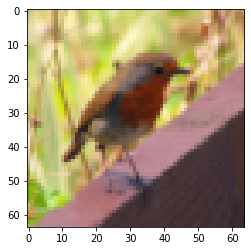

In [67]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
print(train_set_x_orig.shape)
# Example of a picture
index = 10
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

### 训练集，训练集标签，测试集，测试集标签

In [68]:
print("训练集的大小", train_set_x_orig.shape, "训练集的标签", train_set_y.shape, "测试集的大小",  test_set_x_orig.shape, "测试集的标签", test_set_y.shape)

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练集的大小 (209, 64, 64, 3) 训练集的标签 (1, 209) 测试集的大小 (50, 64, 64, 3) 测试集的标签 (1, 50)
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### 扁平化

In [69]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


### 归一化

In [70]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0
X = train_set_x
Y = train_set_y

### sigmoid和deri_sigmoid函数

In [71]:
def sigmoid(z):
    s = 1.0 / (1 + np.exp(-z))
    return s
print(sigmoid(5))
print(sigmoid(0))
print(sigmoid(-5))

def deri_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

0.9933071490757153
0.5
0.0066928509242848554


### 多层神经网络设置

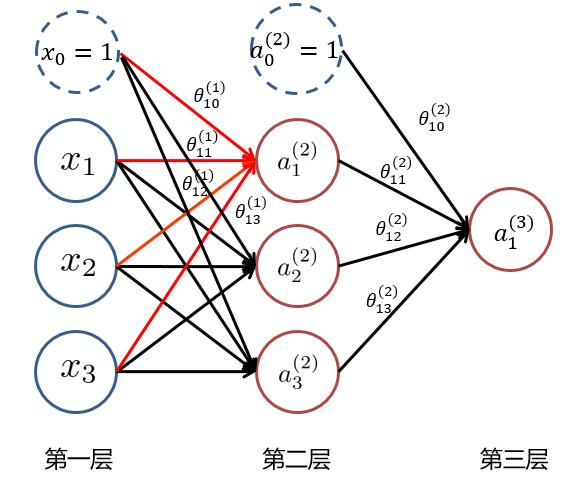

In [72]:
numbers = 3 # 神经网络层数
n1 = 12288 # 第一层神经元个数
n2 = 500 # 第二层神经元个数
n3 = 1 # 第三层神经元个数

### 初始化参数

In [82]:
def initialize_parameters(n1, n2, n3):
    w1 = np.random.randn(n1, n2)
    w2 = np.random.randn(n2, n3)
    b1 = np.random.randn(n2,1)
    b2 = np.random.randn(n3,1)
    
    print("w1 shape: ", w1.shape)
    print("w2 shape: ", w2.shape)
    print("b1 shape: ", b1.shape)
    print("b2 shape: ", b2.shape)    
    
    return w1, w2, b1, b2

w1, w2, b1, b2 = initialize_parameters(n1, n2, n3)
    

w1 shape:  (12288, 500)
w2 shape:  (500, 1)
b1 shape:  (500, 1)
b2 shape:  (1, 1)


### 向前传播

In [83]:
def propagate(w1, w2, b1, b2, X, Y):
#     print("the shape of X: ", X.shape)
#     print("the shape of Y: ", Y.shape)
#     print("the shape of w1: ", w1.shape)
#     print("the shape of b1: ", b1.shape)
#     print("the shape of w2: ", w2.shape)
#     print("the shape of b2: ", b2.shape)
    Z1 = np.dot(w1.T, X) + b1
    A1 = sigmoid(Z1)
#     print("the shape of Z1: ", Z1.shape)
#     print("the shape of A1: ", A1.shape)
    
    Z2 = np.dot(w2.T, A1) + b2
    A2 = sigmoid(Z2)
#     print("the shape of Z2: ", Z2.shape)
#     print("the shape of A2: ", A2.shape)
    
    m = X.shape[1]
    epison = 1e-5
    
    J = -1.0/m * np.sum(Y * np.log(A2+epison) + (1-Y) * np.log(1-A2+epison), axis=1)
#     J = -1.0 / m * np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon), axis=1)
    print("The J before squeeze: ", J)
    J = np.squeeze(J)
    print("The J after squeeze: ", J)
    
    # 更新参数
    dw2 = 1.0/m * np.dot(A1, (A2 - Y).T)
    db2 = 1.0/m * np.sum((A2 - Y), axis=1).reshape(1,1)
    delta1 = np.dot((A2-Y).T, w2.T) * deri_sigmoid(Z1).T
    dw1 = 1.0/m * np.dot(X, delta1)
    db1 = 1.0/m * np.dot(deri_sigmoid(Z1), (A2-Y).T) * w2
    
#     print("the shape of dw1: ", dw1.shape)
#     print("the shape of db1: ", db1.shape)
#     print("the shape of dw2: ", dw2.shape)
#     print("the shape of db2: ", db2.shape)
    
    assert(w1.shape == dw1.shape)
    assert(w2.shape == dw2.shape)
    assert(b1.shape == db1.shape)
    assert(b2.shape == db2.shape)
    assert(db1.dtype == float)
    assert(db2.dtype == float)
    assert(J.shape == ())
    
    
    return J, dw1, dw2, db1, db2

# propagate(w1, w2, b1, b2, X, Y, learning_rate=0.05)
    
    

### 优化参数

In [95]:
def optimize(w1, w2, b1, b2, X, Y, epochs=100, learning_rate=0.05):
    for i in range(epochs):
        dw1, dw2, db1, db2 = propagate(w1, w2, b1, b2, X, Y)
        w2 = w2 - learning_rate * dw2
        b2 = b2 - learning_rate * db2
        w1 = w1 - learning_rate * dw1
        b1 = b1 - learning_rate * db1
        
#         if i % 100 == 0:
#             print(J)
    
    return w1,b1,w2,b2
    

w1, b1, w2, b2 = optimize(w1, w2, b1, b2, X, Y, epochs=10000, learning_rate=0.05)

The J before squeeze:  [3.77870184]
The J after squeeze:  3.7787018439746327
The J before squeeze:  [2.64342182]
The J after squeeze:  2.6434218225878237
The J before squeeze:  [2.44075153]
The J after squeeze:  2.4407515257367423
The J before squeeze:  [2.2971742]
The J after squeeze:  2.2971742015273295
The J before squeeze:  [2.17690299]
The J after squeeze:  2.176902986060583
The J before squeeze:  [2.07712672]
The J after squeeze:  2.0771267178022996
The J before squeeze:  [1.99110783]
The J after squeeze:  1.9911078346245292
The J before squeeze:  [1.91486746]
The J after squeeze:  1.9148674638670184
The J before squeeze:  [1.84541102]
The J after squeeze:  1.8454110229874292
The J before squeeze:  [1.78088697]
The J after squeeze:  1.780886974504257
The J before squeeze:  [1.7201256]
The J after squeeze:  1.720125602954889
The J before squeeze:  [1.66351078]
The J after squeeze:  1.6635107820382948
The J before squeeze:  [1.61137254]
The J after squeeze:  1.6113725353830646
The 

The J before squeeze:  [0.31544787]
The J after squeeze:  0.3154478702948696
The J before squeeze:  [0.31203382]
The J after squeeze:  0.31203381555389686
The J before squeeze:  [0.30864561]
The J after squeeze:  0.30864560953232884
The J before squeeze:  [0.30528988]
The J after squeeze:  0.3052898839269083
The J before squeeze:  [0.3019817]
The J after squeeze:  0.3019817041564912
The J before squeeze:  [0.29874255]
The J after squeeze:  0.2987425524848992
The J before squeeze:  [0.29559367]
The J after squeeze:  0.29559366635358975
The J before squeeze:  [0.29254846]
The J after squeeze:  0.29254846410607793
The J before squeeze:  [0.28960946]
The J after squeeze:  0.2896094599081525
The J before squeeze:  [0.2867707]
The J after squeeze:  0.2867706988472338
The J before squeeze:  [0.28402227]
The J after squeeze:  0.2840222698487758
The J before squeeze:  [0.28135374]
The J after squeeze:  0.28135373761312943
The J before squeeze:  [0.27875576]
The J after squeeze:  0.2787557614423

The J before squeeze:  [0.15445529]
The J after squeeze:  0.1544552889719011
The J before squeeze:  [0.15379625]
The J after squeeze:  0.15379625304306782
The J before squeeze:  [0.15314275]
The J after squeeze:  0.15314274643696943
The J before squeeze:  [0.15249465]
The J after squeeze:  0.15249464993696768
The J before squeeze:  [0.15185185]
The J after squeeze:  0.15185184576710234
The J before squeeze:  [0.15121422]
The J after squeeze:  0.1512142176255331
The J before squeeze:  [0.15058165]
The J after squeeze:  0.1505816507358349
The J before squeeze:  [0.14995403]
The J after squeeze:  0.1499540319157645
The J before squeeze:  [0.14933125]
The J after squeeze:  0.14933124966379216
The J before squeeze:  [0.14871319]
The J after squeeze:  0.14871319426421428
The J before squeeze:  [0.14809976]
The J after squeeze:  0.1480997579122853
The J before squeeze:  [0.14749083]
The J after squeeze:  0.1474908348612304
The J before squeeze:  [0.14688632]
The J after squeeze:  0.1468863215

The J before squeeze:  [0.1026923]
The J after squeeze:  0.1026922950636669
The J before squeeze:  [0.10233053]
The J after squeeze:  0.10233052512567525
The J before squeeze:  [0.10197014]
The J after squeeze:  0.10197013716580154
The J before squeeze:  [0.10161111]
The J after squeeze:  0.10161110565098573
The J before squeeze:  [0.1012534]
The J after squeeze:  0.10125340485731814
The J before squeeze:  [0.10089701]
The J after squeeze:  0.10089700892696507
The J before squeeze:  [0.10054189]
The J after squeeze:  0.10054189190600607
The J before squeeze:  [0.10018803]
The J after squeeze:  0.10018802776455565
The J before squeeze:  [0.09983539]
The J after squeeze:  0.09983539040048874
The J before squeeze:  [0.09948395]
The J after squeeze:  0.09948395362800387
The J before squeeze:  [0.09913369]
The J after squeeze:  0.09913369115204873
The J before squeeze:  [0.09878458]
The J after squeeze:  0.09878457652942438
The J before squeeze:  [0.09843658]
The J after squeeze:  0.0984365

The J before squeeze:  [0.06868216]
The J after squeeze:  0.06868216311734762
The J before squeeze:  [0.06845694]
The J after squeeze:  0.06845694113712504
The J before squeeze:  [0.06823271]
The J after squeeze:  0.06823270902831233
The J before squeeze:  [0.06800945]
The J after squeeze:  0.06800944668397342
The J before squeeze:  [0.06778713]
The J after squeeze:  0.06778713489384242
The J before squeeze:  [0.06756576]
The J after squeeze:  0.0675657552643467
The J before squeeze:  [0.06734529]
The J after squeeze:  0.06734529014603144
The J before squeeze:  [0.06712572]
The J after squeeze:  0.06712572256741921
The J before squeeze:  [0.06690704]
The J after squeeze:  0.06690703617447243
The J before squeeze:  [0.06668922]
The J after squeeze:  0.0666892151749391
The J before squeeze:  [0.06647224]
The J after squeeze:  0.06647224428695218
The J before squeeze:  [0.06625611]
The J after squeeze:  0.06625610869133912
The J before squeeze:  [0.06604079]
The J after squeeze:  0.066040

The J before squeeze:  [0.04675512]
The J after squeeze:  0.04675511892882121
The J before squeeze:  [0.04656926]
The J after squeeze:  0.04656925986104288
The J before squeeze:  [0.04638629]
The J after squeeze:  0.04638628805090414
The J before squeeze:  [0.04620611]
The J after squeeze:  0.04620610891445868
The J before squeeze:  [0.04602862]
The J after squeeze:  0.046028621983031405
The J before squeeze:  [0.04585372]
The J after squeeze:  0.045853723174881664
The J before squeeze:  [0.04568131]
The J after squeeze:  0.04568130672187124
The J before squeeze:  [0.04551127]
The J after squeeze:  0.04551126677457336
The J before squeeze:  [0.0453435]
The J after squeeze:  0.04534349871219428
The J before squeeze:  [0.0451779]
The J after squeeze:  0.04517790018584274
The J before squeeze:  [0.04501437]
The J after squeeze:  0.045014371924978376
The J before squeeze:  [0.04485282]
The J after squeeze:  0.04485281833718185
The J before squeeze:  [0.04469315]
The J after squeeze:  0.044

The J before squeeze:  [0.03341566]
The J after squeeze:  0.033415662832074415
The J before squeeze:  [0.03332299]
The J after squeeze:  0.03332299095712137
The J before squeeze:  [0.03323076]
The J after squeeze:  0.033230764827071574
The J before squeeze:  [0.03313898]
The J after squeeze:  0.033138982897361
The J before squeeze:  [0.03304764]
The J after squeeze:  0.03304764361966348
The J before squeeze:  [0.03295675]
The J after squeeze:  0.03295674544195766
The J before squeeze:  [0.03286629]
The J after squeeze:  0.03286628680875263
The J before squeeze:  [0.03277627]
The J after squeeze:  0.032776266161464236
The J before squeeze:  [0.03268668]
The J after squeeze:  0.032686681938930394
The J before squeeze:  [0.03259753]
The J after squeeze:  0.0325975325780616
The J before squeeze:  [0.03250882]
The J after squeeze:  0.03250881651460903
The J before squeeze:  [0.03242053]
The J after squeeze:  0.03242053218404331
The J before squeeze:  [0.03233268]
The J after squeeze:  0.032

The J before squeeze:  [0.02577795]
The J after squeeze:  0.025777949038125046
The J before squeeze:  [0.0257237]
The J after squeeze:  0.025723704847025772
The J before squeeze:  [0.02566973]
The J after squeeze:  0.025669728997581936
The J before squeeze:  [0.02561602]
The J after squeeze:  0.025616020173024678
The J before squeeze:  [0.02556258]
The J after squeeze:  0.0255625770796778
The J before squeeze:  [0.0255094]
The J after squeeze:  0.02550939844438534
The J before squeeze:  [0.02545648]
The J after squeeze:  0.025456483011855702
The J before squeeze:  [0.02540383]
The J after squeeze:  0.025403829541945512
The J before squeeze:  [0.02535144]
The J after squeeze:  0.025351436806909048
The J before squeeze:  [0.0252993]
The J after squeeze:  0.025299303588639094
The J before squeeze:  [0.02524743]
The J after squeeze:  0.02524742867592336
The J before squeeze:  [0.02519581]
The J after squeeze:  0.025195810861742662
The J before squeeze:  [0.02514445]
The J after squeeze:  0

The J before squeeze:  [0.02129092]
The J after squeeze:  0.02129092346859072
The J before squeeze:  [0.02125735]
The J after squeeze:  0.021257346567656408
The J before squeeze:  [0.0212239]
The J after squeeze:  0.02122390035446067
The J before squeeze:  [0.02119058]
The J after squeeze:  0.021190583959493584
The J before squeeze:  [0.0211574]
The J after squeeze:  0.02115739652267252
The J before squeeze:  [0.02112434]
The J after squeeze:  0.021124337193180444
The J before squeeze:  [0.02109141]
The J after squeeze:  0.021091405129307263
The J before squeeze:  [0.0210586]
The J after squeeze:  0.021058599498294046
The J before squeeze:  [0.02102592]
The J after squeeze:  0.021025919476180793
The J before squeeze:  [0.02099336]
The J after squeeze:  0.020993364247656684
The J before squeeze:  [0.02096093]
The J after squeeze:  0.020960933005914117
The J before squeeze:  [0.02092862]
The J after squeeze:  0.02092862495250465
The J before squeeze:  [0.02089644]
The J after squeeze:  0

The J before squeeze:  [0.0183495]
The J after squeeze:  0.018349495254763912
The J before squeeze:  [0.01832613]
The J after squeeze:  0.01832612528572121
The J before squeeze:  [0.01830283]
The J after squeeze:  0.018302826955763726
The J before squeeze:  [0.0182796]
The J after squeeze:  0.018279599899236013
The J before squeeze:  [0.01825644]
The J after squeeze:  0.01825644375284799
The J before squeeze:  [0.01823336]
The J after squeeze:  0.01823335815565207
The J before squeeze:  [0.01821034]
The J after squeeze:  0.018210342749021332
The J before squeeze:  [0.0181874]
The J after squeeze:  0.018187397176627092
The J before squeeze:  [0.01816452]
The J after squeeze:  0.01816452108441751
The J before squeeze:  [0.01814171]
The J after squeeze:  0.018141714120596047
The J before squeeze:  [0.01811898]
The J after squeeze:  0.018118975935601012
The J before squeeze:  [0.01809631]
The J after squeeze:  0.01809630618208444
The J before squeeze:  [0.0180737]
The J after squeeze:  0.0

The J before squeeze:  [0.0162278]
The J after squeeze:  0.016227799938883777
The J before squeeze:  [0.01621032]
The J after squeeze:  0.01621031546389242
The J before squeeze:  [0.01619287]
The J after squeeze:  0.016192874067376434
The J before squeeze:  [0.01617548]
The J after squeeze:  0.016175475550897968
The J before squeeze:  [0.01615812]
The J after squeeze:  0.01615811971711639
The J before squeeze:  [0.01614081]
The J after squeeze:  0.016140806369783402
The J before squeeze:  [0.01612354]
The J after squeeze:  0.016123535313738075
The J before squeeze:  [0.01610631]
The J after squeeze:  0.01610630635490186
The J before squeeze:  [0.01608912]
The J after squeeze:  0.01608911930027407
The J before squeeze:  [0.01607197]
The J after squeeze:  0.0160719739579274
The J before squeeze:  [0.01605487]
The J after squeeze:  0.016054870137002894
The J before squeeze:  [0.01603781]
The J after squeeze:  0.0160378076477065
The J before squeeze:  [0.01602079]
The J after squeeze:  0.0

The J before squeeze:  [0.01458102]
The J after squeeze:  0.014581019767553422
The J before squeeze:  [0.01456719]
The J after squeeze:  0.014567194748982182
The J before squeeze:  [0.0145534]
The J after squeeze:  0.014553397419225171
The J before squeeze:  [0.01453963]
The J after squeeze:  0.014539627686386052
The J before squeeze:  [0.01452589]
The J after squeeze:  0.014525885459547267
The J before squeeze:  [0.01451217]
The J after squeeze:  0.014512170648767404
The J before squeeze:  [0.01449848]
The J after squeeze:  0.01449848316507695
The J before squeeze:  [0.01448482]
The J after squeeze:  0.01448482292047446
The J before squeeze:  [0.01447119]
The J after squeeze:  0.014471189827922257
The J before squeeze:  [0.01445758]
The J after squeeze:  0.014457583801341859
The J before squeeze:  [0.014444]
The J after squeeze:  0.01444400475560897
The J before squeeze:  [0.01443045]
The J after squeeze:  0.014430452606548787
The J before squeeze:  [0.01441693]
The J after squeeze:  

The J before squeeze:  [0.01326726]
The J after squeeze:  0.013267258193415876
The J before squeeze:  [0.01325598]
The J after squeeze:  0.013255980665090695
The J before squeeze:  [0.01324472]
The J after squeeze:  0.013244724722751637
The J before squeeze:  [0.01323349]
The J after squeeze:  0.013233490319922549
The J before squeeze:  [0.01322228]
The J after squeeze:  0.013222277410000174
The J before squeeze:  [0.01321109]
The J after squeeze:  0.013211085946251444
The J before squeeze:  [0.01319992]
The J after squeeze:  0.01319991588181145
The J before squeeze:  [0.01318877]
The J after squeeze:  0.013188767169680942
The J before squeeze:  [0.01317764]
The J after squeeze:  0.013177639762724814
The J before squeeze:  [0.01316653]
The J after squeeze:  0.01316653361367102
The J before squeeze:  [0.01315545]
The J after squeeze:  0.013155448675108695
The J before squeeze:  [0.01314438]
The J after squeeze:  0.013144384899487882
The J before squeeze:  [0.01313334]
The J after squeez

The J before squeeze:  [0.01219174]
The J after squeeze:  0.012191738689474102
The J before squeeze:  [0.01218246]
The J after squeeze:  0.012182456046280179
The J before squeeze:  [0.01217319]
The J after squeeze:  0.012173189733339909
The J before squeeze:  [0.01216394]
The J after squeeze:  0.012163939702658671
The J before squeeze:  [0.01215471]
The J after squeeze:  0.012154705906369943
The J before squeeze:  [0.01214549]
The J after squeeze:  0.012145488296736413
The J before squeeze:  [0.01213629]
The J after squeeze:  0.01213628682615057
The J before squeeze:  [0.0121271]
The J after squeeze:  0.012127101447136463
The J before squeeze:  [0.01211793]
The J after squeeze:  0.012117932112349922
The J before squeeze:  [0.01210878]
The J after squeeze:  0.012108778774579991
The J before squeeze:  [0.01209964]
The J after squeeze:  0.012099641386749509
The J before squeeze:  [0.01209052]
The J after squeeze:  0.012090519901915994
The J before squeeze:  [0.01208141]
The J after squeez

The J before squeeze:  [0.01129789]
The J after squeeze:  0.011297886476781984
The J before squeeze:  [0.01129008]
The J after squeeze:  0.011290082368173342
The J before squeeze:  [0.01128229]
The J after squeeze:  0.011282290302123276
The J before squeeze:  [0.01127451]
The J after squeeze:  0.011274510244727004
The J before squeeze:  [0.01126674]
The J after squeeze:  0.01126674216219557
The J before squeeze:  [0.01125899]
The J after squeeze:  0.011258986020854738
The J before squeeze:  [0.01125124]
The J after squeeze:  0.011251241787144721
The J before squeeze:  [0.01124351]
The J after squeeze:  0.0112435094276199
The J before squeeze:  [0.01123579]
The J after squeeze:  0.011235788908947946
The J before squeeze:  [0.01122808]
The J after squeeze:  0.011228080197909473
The J before squeeze:  [0.01122038]
The J after squeeze:  0.011220383261397779
The J before squeeze:  [0.0112127]
The J after squeeze:  0.011212698066418073
The J before squeeze:  [0.01120502]
The J after squeeze:

The J before squeeze:  [0.01053836]
The J after squeeze:  0.010538358369068582
The J before squeeze:  [0.01053165]
The J after squeeze:  0.010531653050865944
The J before squeeze:  [0.01052496]
The J after squeeze:  0.010524956761477801
The J before squeeze:  [0.01051827]
The J after squeeze:  0.010518269476784125
The J before squeeze:  [0.01051159]
The J after squeeze:  0.01051159117273999
The J before squeeze:  [0.01050492]
The J after squeeze:  0.010504921825375107
The J before squeeze:  [0.01049826]
The J after squeeze:  0.010498261410793781
The J before squeeze:  [0.01049161]
The J after squeeze:  0.010491609905174582
The J before squeeze:  [0.01048497]
The J after squeeze:  0.01048496728477019
The J before squeeze:  [0.01047833]
The J after squeeze:  0.01047833352590709
The J before squeeze:  [0.01047171]
The J after squeeze:  0.010471708604985239
The J before squeeze:  [0.01046509]
The J after squeeze:  0.010465092498478042
The J before squeeze:  [0.01045849]
The J after squeeze

The J before squeeze:  [0.00986767]
The J after squeeze:  0.009867669707545598
The J before squeeze:  [0.00986181]
The J after squeeze:  0.009861807570975444
The J before squeeze:  [0.00985595]
The J after squeeze:  0.009855952271699818
The J before squeeze:  [0.0098501]
The J after squeeze:  0.00985010379271333
The J before squeeze:  [0.00984426]
The J after squeeze:  0.009844262117072313
The J before squeeze:  [0.00983843]
The J after squeeze:  0.009838427227895206
The J before squeeze:  [0.0098326]
The J after squeeze:  0.009832599108362091
The J before squeeze:  [0.00982678]
The J after squeeze:  0.009826777741714863
The J before squeeze:  [0.00982096]
The J after squeeze:  0.009820963111257203
The J before squeeze:  [0.00981516]
The J after squeeze:  0.00981515520035435
The J before squeeze:  [0.00980935]
The J after squeeze:  0.009809353992433326
The J before squeeze:  [0.00980356]
The J after squeeze:  0.009803559470982683
The J before squeeze:  [0.00979777]
The J after squeeze:

The J before squeeze:  [0.00928135]
The J after squeeze:  0.009281353889881034
The J before squeeze:  [0.00927613]
The J after squeeze:  0.009276133494174948
The J before squeeze:  [0.00927092]
The J after squeeze:  0.009270918462534894
The J before squeeze:  [0.00926571]
The J after squeeze:  0.009265708783921647
The J before squeeze:  [0.0092605]
The J after squeeze:  0.009260504447339269
The J before squeeze:  [0.00925531]
The J after squeeze:  0.009255305441834515
The J before squeeze:  [0.00925011]
The J after squeeze:  0.009250111756496508
The J before squeeze:  [0.00924492]
The J after squeeze:  0.009244923380456255
The J before squeeze:  [0.00923974]
The J after squeeze:  0.009239740302886218
The J before squeeze:  [0.00923456]
The J after squeeze:  0.009234562512999877
The J before squeeze:  [0.00922939]
The J after squeeze:  0.009229390000051236
The J before squeeze:  [0.00922422]
The J after squeeze:  0.009224222753334382
The J before squeeze:  [0.00921906]
The J after squee

The J before squeeze:  [0.00875117]
The J after squeeze:  0.00875117104016228
The J before squeeze:  [0.00874647]
The J after squeeze:  0.008746468015853841
The J before squeeze:  [0.00874177]
The J after squeeze:  0.008741769319900422
The J before squeeze:  [0.00873707]
The J after squeeze:  0.008737074943025565
The J before squeeze:  [0.00873238]
The J after squeeze:  0.008732384875943595
The J before squeeze:  [0.0087277]
The J after squeeze:  0.008727699109359043
The J before squeeze:  [0.00872302]
The J after squeeze:  0.00872301763396654
The J before squeeze:  [0.00871834]
The J after squeeze:  0.00871834044045029
The J before squeeze:  [0.00871367]
The J after squeeze:  0.008713667519483707
The J before squeeze:  [0.008709]
The J after squeeze:  0.00870899886172905
The J before squeeze:  [0.00870433]
The J after squeeze:  0.00870433445783713
The J before squeeze:  [0.00869967]
The J after squeeze:  0.008699674298446905
The J before squeeze:  [0.00869502]
The J after squeeze:  0.

The J before squeeze:  [0.00827057]
The J after squeeze:  0.008270566238921685
The J before squeeze:  [0.00826627]
The J after squeeze:  0.0082662700214396
The J before squeeze:  [0.00826198]
The J after squeeze:  0.008261977012350399
The J before squeeze:  [0.00825769]
The J after squeeze:  0.008257687199056419
The J before squeeze:  [0.0082534]
The J after squeeze:  0.008253400568895116
The J before squeeze:  [0.00824912]
The J after squeeze:  0.008249117109137968
The J before squeeze:  [0.00824484]
The J after squeeze:  0.008244836806989606
The J before squeeze:  [0.00824056]
The J after squeeze:  0.008240559649586528
The J before squeeze:  [0.00823629]
The J after squeeze:  0.008236285623996057
The J before squeeze:  [0.00823201]
The J after squeeze:  0.008232014717215191
The J before squeeze:  [0.00822775]
The J after squeeze:  0.008227746916169454
The J before squeeze:  [0.00822348]
The J after squeeze:  0.008223482207711715
The J before squeeze:  [0.00821922]
The J after squeeze

The J before squeeze:  [0.00783417]
The J after squeeze:  0.007834172392593349
The J before squeeze:  [0.00783012]
The J after squeeze:  0.007830124918521671
The J before squeeze:  [0.00782608]
The J after squeeze:  0.007826078670349337
The J before squeeze:  [0.00782203]
The J after squeeze:  0.007822033618705029
The J before squeeze:  [0.00781799]
The J after squeeze:  0.007817989733930525
The J before squeeze:  [0.00781395]
The J after squeeze:  0.007813946986079028
The J before squeeze:  [0.00780991]
The J after squeeze:  0.007809905344913255
The J before squeeze:  [0.00780586]
The J after squeeze:  0.007805864779903951
The J before squeeze:  [0.00780183]
The J after squeeze:  0.007801825260228302
The J before squeeze:  [0.00779779]
The J after squeeze:  0.007797786754768611
The J before squeeze:  [0.00779375]
The J after squeeze:  0.00779374923211098
The J before squeeze:  [0.00778971]
The J after squeeze:  0.007789712660544217
The J before squeeze:  [0.00778568]
The J after squee

The J before squeeze:  [0.0074052]
The J after squeeze:  0.0074051991622333955
The J before squeeze:  [0.00740109]
The J after squeeze:  0.007401089598305018
The J before squeeze:  [0.00739698]
The J after squeeze:  0.007396978341895833
The J before squeeze:  [0.00739287]
The J after squeeze:  0.007392865428954509
The J before squeeze:  [0.00738875]
The J after squeeze:  0.007388750898894929
The J before squeeze:  [0.00738463]
The J after squeeze:  0.007384634794670311
The J before squeeze:  [0.00738052]
The J after squeeze:  0.007380517162843908
The J before squeeze:  [0.0073764]
The J after squeeze:  0.007376398053657099
The J before squeeze:  [0.00737228]
The J after squeeze:  0.00737227752109386
The J before squeeze:  [0.00736816]
The J after squeeze:  0.007368155622941481
The J before squeeze:  [0.00736403]
The J after squeeze:  0.007364032420847022
The J before squeeze:  [0.00735991]
The J after squeeze:  0.00735990798036983
The J before squeeze:  [0.00735578]
The J after squeeze

The J before squeeze:  [0.00698929]
The J after squeeze:  0.006989292719975968
The J before squeeze:  [0.00698565]
The J after squeeze:  0.006985648828362654
The J before squeeze:  [0.00698201]
The J after squeeze:  0.006982014518139075
The J before squeeze:  [0.00697839]
The J after squeeze:  0.006978389770409566
The J before squeeze:  [0.00697477]
The J after squeeze:  0.0069747745632471716
The J before squeeze:  [0.00697117]
The J after squeeze:  0.006971168871807772
The J before squeeze:  [0.00696757]
The J after squeeze:  0.006967572668444135
The J before squeeze:  [0.00696399]
The J after squeeze:  0.0069639859228198256
The J before squeeze:  [0.00696041]
The J after squeeze:  0.00696040860202273
The J before squeeze:  [0.00695684]
The J after squeeze:  0.006956840670677882
The J before squeeze:  [0.00695328]
The J after squeeze:  0.006953282091059209
The J before squeeze:  [0.00694973]
The J after squeeze:  0.006949732823200293
The J before squeeze:  [0.00694619]
The J after squ

The J before squeeze:  [0.0066523]
The J after squeeze:  0.006652299081544819
The J before squeeze:  [0.00664937]
The J after squeeze:  0.006649368306549076
The J before squeeze:  [0.00664644]
The J after squeeze:  0.0066464417867899
The J before squeeze:  [0.00664352]
The J after squeeze:  0.006643519489731496
The J before squeeze:  [0.0066406]
The J after squeeze:  0.006640601383305544
The J before squeeze:  [0.00663769]
The J after squeeze:  0.006637687435905367
The J before squeeze:  [0.00663478]
The J after squeeze:  0.006634777616379985
The J before squeeze:  [0.00663187]
The J after squeeze:  0.006631871894028446
The J before squeeze:  [0.00662897]
The J after squeeze:  0.006628970238593798
The J before squeeze:  [0.00662607]
The J after squeeze:  0.006626072620257242
The J before squeeze:  [0.00662318]
The J after squeeze:  0.006623179009632422
The J before squeeze:  [0.00662029]
The J after squeeze:  0.006620289377759586
The J before squeeze:  [0.0066174]
The J after squeeze: 

The J before squeeze:  [0.00636343]
The J after squeeze:  0.006363431053142735
The J before squeeze:  [0.00636083]
The J after squeeze:  0.006360832885770832
The J before squeeze:  [0.00635824]
The J after squeeze:  0.006358237212016689
The J before squeeze:  [0.00635564]
The J after squeeze:  0.006355644024671627
The J before squeeze:  [0.00635305]
The J after squeeze:  0.006353053316623106
The J before squeeze:  [0.00635047]
The J after squeeze:  0.006350465080853006
The J before squeeze:  [0.00634788]
The J after squeeze:  0.006347879310436246
The J before squeeze:  [0.0063453]
The J after squeeze:  0.006345295998539238
The J before squeeze:  [0.00634272]
The J after squeeze:  0.006342715138418433
The J before squeeze:  [0.00634014]
The J after squeeze:  0.006340136723418926
The J before squeeze:  [0.00633756]
The J after squeeze:  0.00633756074697293
The J before squeeze:  [0.00633499]
The J after squeeze:  0.006334987202598585
The J before squeeze:  [0.00633242]
The J after squeez

The J before squeeze:  [0.00610086]
The J after squeeze:  0.006100863652156127
The J before squeeze:  [0.0060985]
The J after squeeze:  0.006098502339721298
The J before squeeze:  [0.00609614]
The J after squeeze:  0.006096143076537608
The J before squeeze:  [0.00609379]
The J after squeeze:  0.006093785859988077
The J before squeeze:  [0.00609143]
The J after squeeze:  0.006091430687465876
The J before squeeze:  [0.00608908]
The J after squeeze:  0.0060890775563739175
The J before squeeze:  [0.00608673]
The J after squeeze:  0.006086726464124682
The J before squeeze:  [0.00608438]
The J after squeeze:  0.006084377408139768
The J before squeeze:  [0.00608203]
The J after squeeze:  0.006082030385849651
The J before squeeze:  [0.00607969]
The J after squeeze:  0.006079685394693419
The J before squeeze:  [0.00607734]
The J after squeeze:  0.006077342432118332
The J before squeeze:  [0.006075]
The J after squeeze:  0.0060750014955797274
The J before squeeze:  [0.00607266]
The J after squee

The J before squeeze:  [0.00586149]
The J after squeeze:  0.005861490318092253
The J before squeeze:  [0.00585933]
The J after squeeze:  0.005859332533754687
The J before squeeze:  [0.00585718]
The J after squeeze:  0.005857176539997973
The J before squeeze:  [0.00585502]
The J after squeeze:  0.0058550223343862345
The J before squeeze:  [0.00585287]
The J after squeeze:  0.005852869914483076
The J before squeeze:  [0.00585072]
The J after squeeze:  0.005850719277851367
The J before squeeze:  [0.00584857]
The J after squeeze:  0.005848570422053737
The J before squeeze:  [0.00584642]
The J after squeeze:  0.005846423344651982
The J before squeeze:  [0.00584428]
The J after squeeze:  0.005844278043207685
The J before squeeze:  [0.00584213]
The J after squeeze:  0.005842134515281827
The J before squeeze:  [0.00583999]
The J after squeeze:  0.005839992758435061
The J before squeeze:  [0.00583785]
The J after squeeze:  0.005837852770227709
The J before squeeze:  [0.00583571]
The J after squ

The J before squeeze:  [0.00564424]
The J after squeeze:  0.005644243669654659
The J before squeeze:  [0.00564226]
The J after squeeze:  0.0056422606669032024
The J before squeeze:  [0.00564028]
The J after squeeze:  0.005640279202980226
The J before squeeze:  [0.0056383]
The J after squeeze:  0.005638299275600698
The J before squeeze:  [0.00563632]
The J after squeeze:  0.0056363208824828405
The J before squeeze:  [0.00563434]
The J after squeeze:  0.0056343440213483765
The J before squeeze:  [0.00563237]
The J after squeeze:  0.005632368689922336
The J before squeeze:  [0.00563039]
The J after squeeze:  0.005630394885933273
The J before squeeze:  [0.00562842]
The J after squeeze:  0.005628422607113148
The J before squeeze:  [0.00562645]
The J after squeeze:  0.00562645185119745
The J before squeeze:  [0.00562448]
The J after squeeze:  0.005624482615925127
The J before squeeze:  [0.00562251]
The J after squeeze:  0.005622514899038732
The J before squeeze:  [0.00562055]
The J after squ

The J before squeeze:  [0.00544219]
The J after squeeze:  0.005442186908952534
The J before squeeze:  [0.00544036]
The J after squeeze:  0.00544035505104094
The J before squeeze:  [0.00543852]
The J after squeeze:  0.00543852451190972
The J before squeeze:  [0.0054367]
The J after squeeze:  0.005436695289716343
The J before squeeze:  [0.00543487]
The J after squeeze:  0.005434867382622806
The J before squeeze:  [0.00543304]
The J after squeeze:  0.0054330407887956175
The J before squeeze:  [0.00543122]
The J after squeeze:  0.00543121550640591
The J before squeeze:  [0.00542939]
The J after squeeze:  0.005429391533629205
The J before squeeze:  [0.00542757]
The J after squeeze:  0.005427568868645756
The J before squeeze:  [0.00542575]
The J after squeeze:  0.005425747509640187
The J before squeeze:  [0.00542393]
The J after squeeze:  0.0054239274548016836
The J before squeeze:  [0.00542211]
The J after squeeze:  0.0054221087023240125
The J before squeeze:  [0.00542029]
The J after squee

The J before squeeze:  [0.00525672]
The J after squeeze:  0.005256718502982717
The J before squeeze:  [0.00525502]
The J after squeeze:  0.005255015898492992
The J before squeeze:  [0.00525331]
The J after squeeze:  0.0052533144436751455
The J before squeeze:  [0.00525161]
The J after squeeze:  0.00525161413714767
The J before squeeze:  [0.00524991]
The J after squeeze:  0.005249914977533338
The J before squeeze:  [0.00524822]
The J after squeeze:  0.005248216963459035
The J before squeeze:  [0.00524652]
The J after squeeze:  0.005246520093555637
The J before squeeze:  [0.00524482]
The J after squeeze:  0.005244824366458306
The J before squeeze:  [0.00524313]
The J after squeeze:  0.005243129780806183
The J before squeeze:  [0.00524144]
The J after squeeze:  0.005241436335242584
The J before squeeze:  [0.00523974]
The J after squeeze:  0.005239744028414877
The J before squeeze:  [0.00523805]
The J after squeeze:  0.005238052858974508
The J before squeeze:  [0.00523636]
The J after sque

The J before squeeze:  [0.00508398]
The J after squeeze:  0.005083982317048614
The J before squeeze:  [0.00508239]
The J after squeeze:  0.005082393623866411
The J before squeeze:  [0.00508081]
The J after squeeze:  0.005080805956390328
The J before squeeze:  [0.00507922]
The J after squeeze:  0.0050792193136270395
The J before squeeze:  [0.00507763]
The J after squeeze:  0.0050776336945864056
The J before squeeze:  [0.00507605]
The J after squeeze:  0.005076049098281352
The J before squeeze:  [0.00507447]
The J after squeeze:  0.005074465523727982
The J before squeeze:  [0.00507288]
The J after squeeze:  0.005072882969945433
The J before squeeze:  [0.0050713]
The J after squeeze:  0.005071301435955998
The J before squeeze:  [0.00506972]
The J after squeeze:  0.005069720920785002
The J before squeeze:  [0.00506814]
The J after squeeze:  0.005068141423460898
The J before squeeze:  [0.00506656]
The J after squeeze:  0.005066562943015146
The J before squeeze:  [0.00506499]
The J after squ

The J before squeeze:  [0.00492408]
The J after squeeze:  0.004924084209629793
The J before squeeze:  [0.0049226]
The J after squeeze:  0.004922597377995908
The J before squeeze:  [0.00492111]
The J after squeeze:  0.004921111483012715
The J before squeeze:  [0.00491963]
The J after squeeze:  0.004919626523935707
The J before squeeze:  [0.00491814]
The J after squeeze:  0.004918142500021843
The J before squeeze:  [0.00491666]
The J after squeeze:  0.004916659410529633
The J before squeeze:  [0.00491518]
The J after squeeze:  0.004915177254719146
The J before squeeze:  [0.0049137]
The J after squeeze:  0.00491369603185196
The J before squeeze:  [0.00491222]
The J after squeeze:  0.004912215741191123
The J before squeeze:  [0.00491074]
The J after squeeze:  0.004910736382001186
The J before squeeze:  [0.00490926]
The J after squeeze:  0.004909257953548152
The J before squeeze:  [0.00490778]
The J after squeeze:  0.004907780455099431
The J before squeeze:  [0.0049063]
The J after squeeze:

The J before squeeze:  [0.00477156]
The J after squeeze:  0.004771555039121878
The J before squeeze:  [0.00477016]
The J after squeeze:  0.004770163573152828
The J before squeeze:  [0.00476877]
The J after squeeze:  0.004768772970674481
The J before squeeze:  [0.00476738]
The J after squeeze:  0.004767383231026795
The J before squeeze:  [0.00476599]
The J after squeeze:  0.00476599435354996
The J before squeeze:  [0.00476461]
The J after squeeze:  0.004764606337584349
The J before squeeze:  [0.00476322]
The J after squeeze:  0.004763219182470393
The J before squeeze:  [0.00476183]
The J after squeeze:  0.00476183288754873
The J before squeeze:  [0.00476045]
The J after squeeze:  0.004760447452160149
The J before squeeze:  [0.00475906]
The J after squeeze:  0.004759062875645525
The J before squeeze:  [0.00475768]
The J after squeeze:  0.004757679157345893
The J before squeeze:  [0.0047563]
The J after squeeze:  0.004756296296602316
The J before squeeze:  [0.00475491]
The J after squeeze

The J before squeeze:  [0.00462874]
The J after squeeze:  0.004628737832768519
The J before squeeze:  [0.00462743]
The J after squeeze:  0.004627434226510742
The J before squeeze:  [0.00462613]
The J after squeeze:  0.004626131413669238
The J before squeeze:  [0.00462483]
The J after squeeze:  0.0046248293935765945
The J before squeeze:  [0.00462353]
The J after squeeze:  0.004623528165565241
The J before squeeze:  [0.00462223]
The J after squeeze:  0.0046222277289675795
The J before squeeze:  [0.00462093]
The J after squeeze:  0.004620928083115779
The J before squeeze:  [0.00461963]
The J after squeeze:  0.004619629227341975
The J before squeeze:  [0.00461833]
The J after squeeze:  0.004618331160978113
The J before squeeze:  [0.00461703]
The J after squeeze:  0.004617033883356043
The J before squeeze:  [0.00461574]
The J after squeeze:  0.00461573739380749
The J before squeeze:  [0.00461444]
The J after squeeze:  0.004614441691664054
The J before squeeze:  [0.00461315]
The J after squ

The J before squeeze:  [0.00449607]
The J after squeeze:  0.004496065743450292
The J before squeeze:  [0.00449484]
The J after squeeze:  0.0044948417903872655
The J before squeeze:  [0.00449362]
The J after squeeze:  0.00449361856049112
The J before squeeze:  [0.0044924]
The J after squeeze:  0.004492396053097834
The J before squeeze:  [0.00449117]
The J after squeeze:  0.0044911742675436605
The J before squeeze:  [0.00448995]
The J after squeeze:  0.004489953203165018
The J before squeeze:  [0.00448873]
The J after squeeze:  0.004488732859298599
The J before squeeze:  [0.00448751]
The J after squeeze:  0.004487513235281349
The J before squeeze:  [0.00448629]
The J after squeeze:  0.004486294330450482
The J before squeeze:  [0.00448508]
The J after squeeze:  0.004485076144143409
The J before squeeze:  [0.00448386]
The J after squeeze:  0.004483858675697924
The J before squeeze:  [0.00448264]
The J after squeeze:  0.004482641924451957
The J before squeeze:  [0.00448143]
The J after sque

The J before squeeze:  [0.00437022]
The J after squeeze:  0.004370224606909346
The J before squeeze:  [0.00436907]
The J after squeeze:  0.004369073678847264
The J before squeeze:  [0.00436792]
The J after squeeze:  0.004367923405601146
The J before squeeze:  [0.00436677]
The J after squeeze:  0.0043667737865519035
The J before squeeze:  [0.00436562]
The J after squeeze:  0.004365624821081013
The J before squeeze:  [0.00436448]
The J after squeeze:  0.004364476508570588
The J before squeeze:  [0.00436333]
The J after squeeze:  0.004363328848403255
The J before squeeze:  [0.00436218]
The J after squeeze:  0.00436218183996223
The J before squeeze:  [0.00436104]
The J after squeeze:  0.004361035482631361
The J before squeeze:  [0.00435989]
The J after squeeze:  0.0043598897757950806
The J before squeeze:  [0.00435874]
The J after squeeze:  0.004358744718838367
The J before squeeze:  [0.0043576]
The J after squeeze:  0.004357600311146864
The J before squeeze:  [0.00435646]
The J after sque

The J before squeeze:  [0.00425175]
The J after squeeze:  0.004251753905556187
The J before squeeze:  [0.00425067]
The J after squeeze:  0.004250669062965098
The J before squeeze:  [0.00424958]
The J after squeeze:  0.004249584813099022
The J before squeeze:  [0.0042485]
The J after squeeze:  0.004248501155408257
The J before squeeze:  [0.00424742]
The J after squeeze:  0.004247418089343819
The J before squeeze:  [0.00424634]
The J after squeeze:  0.004246335614357374
The J before squeeze:  [0.00424525]
The J after squeeze:  0.004245253729901314
The J before squeeze:  [0.00424417]
The J after squeeze:  0.0042441724354287435
The J before squeeze:  [0.00424309]
The J after squeeze:  0.00424309173039345
The J before squeeze:  [0.00424201]
The J after squeeze:  0.004242011614249932
The J before squeeze:  [0.00424093]
The J after squeeze:  0.004240932086453365
The J before squeeze:  [0.00423985]
The J after squeeze:  0.004239853146459657
The J before squeeze:  [0.00423877]
The J after squee

The J before squeeze:  [0.00414098]
The J after squeeze:  0.004140982004068323
The J before squeeze:  [0.00413996]
The J after squeeze:  0.004139956527034801
The J before squeeze:  [0.00413893]
The J after squeeze:  0.0041389315888072835
The J before squeeze:  [0.00413791]
The J after squeeze:  0.004137907188908582
The J before squeeze:  [0.00413688]
The J after squeeze:  0.004136883326862152
The J before squeeze:  [0.00413586]
The J after squeeze:  0.0041358600021921535
The J before squeeze:  [0.00413484]
The J after squeeze:  0.004134837214423357
The J before squeeze:  [0.00413381]
The J after squeeze:  0.004133814963081249
The J before squeeze:  [0.00413279]
The J after squeeze:  0.0041327932476919755
The J before squeeze:  [0.00413177]
The J after squeeze:  0.004131772067782298
The J before squeeze:  [0.00413075]
The J after squeeze:  0.004130751422879697
The J before squeeze:  [0.00412973]
The J after squeeze:  0.004129731312512295
The J before squeeze:  [0.00412871]
The J after s

The J before squeeze:  [0.00403519]
The J after squeeze:  0.004035191067228328
The J before squeeze:  [0.00403422]
The J after squeeze:  0.004034220172756694
The J before squeeze:  [0.00403325]
The J after squeeze:  0.004033249770063121
The J before squeeze:  [0.00403228]
The J after squeeze:  0.004032279858736391
The J before squeeze:  [0.00403131]
The J after squeeze:  0.004031310438365913
The J before squeeze:  [0.00403034]
The J after squeeze:  0.004030341508541633
The J before squeeze:  [0.00402937]
The J after squeeze:  0.004029373068854121
The J before squeeze:  [0.00402841]
The J after squeeze:  0.004028405118894444
The J before squeeze:  [0.00402744]
The J after squeeze:  0.004027437658254265
The J before squeeze:  [0.00402647]
The J after squeeze:  0.004026470686525854
The J before squeeze:  [0.0040255]
The J after squeeze:  0.004025504203301995
The J before squeeze:  [0.00402454]
The J after squeeze:  0.0040245382081760955
The J before squeeze:  [0.00402357]
The J after sque

The J before squeeze:  [0.00393586]
The J after squeeze:  0.003935857812976391
The J before squeeze:  [0.00393494]
The J after squeeze:  0.003934936412538648
The J before squeeze:  [0.00393402]
The J after squeeze:  0.0039340154636370375
The J before squeeze:  [0.00393309]
The J after squeeze:  0.003933094965914838
The J before squeeze:  [0.00393217]
The J after squeeze:  0.003932174919015796
The J before squeeze:  [0.00393126]
The J after squeeze:  0.003931255322584147
The J before squeeze:  [0.00393034]
The J after squeeze:  0.003930336176264484
The J before squeeze:  [0.00392942]
The J after squeeze:  0.003929417479702009
The J before squeeze:  [0.0039285]
The J after squeeze:  0.003928499232542267
The J before squeeze:  [0.00392758]
The J after squeeze:  0.003927581434431295
The J before squeeze:  [0.00392666]
The J after squeeze:  0.003926664085015616
The J before squeeze:  [0.00392575]
The J after squeeze:  0.003925747183942216
The J before squeeze:  [0.00392483]
The J after sque

The J before squeeze:  [0.00384064]
The J after squeeze:  0.00384063554761159
The J before squeeze:  [0.00383976]
The J after squeeze:  0.003839760109306324
The J before squeeze:  [0.00383889]
The J after squeeze:  0.0038388850871121185
The J before squeeze:  [0.00383801]
The J after squeeze:  0.003838010480715919
The J before squeeze:  [0.00383714]
The J after squeeze:  0.003837136289804982
The J before squeeze:  [0.00383626]
The J after squeeze:  0.0038362625140669726
The J before squeeze:  [0.00383539]
The J after squeeze:  0.003835389153189872
The J before squeeze:  [0.00383452]
The J after squeeze:  0.0038345162068620544
The J before squeeze:  [0.00383364]
The J after squeeze:  0.0038336436747721985
The J before squeeze:  [0.00383277]
The J after squeeze:  0.0038327715566093966
The J before squeeze:  [0.0038319]
The J after squeeze:  0.0038318998520630817
The J before squeeze:  [0.00383103]
The J after squeeze:  0.0038310285608230215
The J before squeeze:  [0.00383016]
The J after

The J before squeeze:  [0.0037501]
The J after squeeze:  0.003750096050569231
The J before squeeze:  [0.00374926]
The J after squeeze:  0.0037492630430814027
The J before squeeze:  [0.00374843]
The J after squeeze:  0.003748430420361828
The J before squeeze:  [0.0037476]
The J after squeeze:  0.003747598182130983
The J before squeeze:  [0.00374677]
The J after squeeze:  0.0037467663281096878
The J before squeeze:  [0.00374593]
The J after squeeze:  0.003745934858018985
The J before squeeze:  [0.0037451]
The J after squeeze:  0.0037451037715802208
The J before squeeze:  [0.00374427]
The J after squeeze:  0.0037442730685149474
The J before squeeze:  [0.00374344]
The J after squeeze:  0.003743442748545119
The J before squeeze:  [0.00374261]
The J after squeeze:  0.003742612811392827
The J before squeeze:  [0.00374178]
The J after squeeze:  0.0037417832567805324
The J before squeeze:  [0.00374095]
The J after squeeze:  0.0037409540844308875
The J before squeeze:  [0.00374013]
The J after s

The J before squeeze:  [0.00366468]
The J after squeeze:  0.0036646799553524683
The J before squeeze:  [0.00366389]
The J after squeeze:  0.0036638858708702626
The J before squeeze:  [0.00366309]
The J after squeeze:  0.003663092143187318
The J before squeeze:  [0.0036623]
The J after squeeze:  0.0036622987720495263
The J before squeeze:  [0.00366151]
The J after squeeze:  0.0036615057572029026
The J before squeeze:  [0.00366071]
The J after squeeze:  0.0036607130983937375
The J before squeeze:  [0.00365992]
The J after squeeze:  0.0036599207953684873
The J before squeeze:  [0.00365913]
The J after squeeze:  0.003659128847873841
The J before squeeze:  [0.00365834]
The J after squeeze:  0.0036583372556566645
The J before squeeze:  [0.00365755]
The J after squeeze:  0.0036575460184640777
The J before squeeze:  [0.00365676]
The J after squeeze:  0.003656755136043372
The J before squeeze:  [0.00365596]
The J after squeeze:  0.003655964608142055
The J before squeeze:  [0.00365517]
The J aft

The J before squeeze:  [0.0035832]
The J after squeeze:  0.0035832025179748143
The J before squeeze:  [0.00358244]
The J after squeeze:  0.0035824445466220035
The J before squeeze:  [0.00358169]
The J after squeeze:  0.0035816869064336223
The J before squeeze:  [0.00358093]
The J after squeeze:  0.003580929597174846
The J before squeeze:  [0.00358017]
The J after squeeze:  0.0035801726186110313
The J before squeeze:  [0.00357942]
The J after squeeze:  0.0035794159705077153
The J before squeeze:  [0.00357866]
The J after squeeze:  0.003578659652630558
The J before squeeze:  [0.0035779]
The J after squeeze:  0.0035779036647454058
The J before squeeze:  [0.00357715]
The J after squeeze:  0.0035771480066182698
The J before squeeze:  [0.00357639]
The J after squeeze:  0.003576392678015296
The J before squeeze:  [0.00357564]
The J after squeeze:  0.0035756376787028205
The J before squeeze:  [0.00357488]
The J after squeeze:  0.003574883008447267
The J before squeeze:  [0.00357413]
The J afte

The J before squeeze:  [0.00350538]
The J after squeeze:  0.003505380398445828
The J before squeeze:  [0.00350466]
The J after squeeze:  0.003504655945618877
The J before squeeze:  [0.00350393]
The J after squeeze:  0.0035039318001078403
The J before squeeze:  [0.00350321]
The J after squeeze:  0.0035032079616927167
The J before squeeze:  [0.00350248]
The J after squeeze:  0.0035024844301536546
The J before squeeze:  [0.00350176]
The J after squeeze:  0.0035017612052709135
The J before squeeze:  [0.00350104]
The J after squeeze:  0.0035010382868248904
The J before squeeze:  [0.00350032]
The J after squeeze:  0.003500315674596064
The J before squeeze:  [0.00349959]
The J after squeeze:  0.00349959336836507
The J before squeeze:  [0.00349887]
The J after squeeze:  0.003498871367912629
The J before squeeze:  [0.00349815]
The J after squeeze:  0.003498149673019631
The J before squeeze:  [0.00349743]
The J after squeeze:  0.0034974282834670653
The J before squeeze:  [0.00349671]
The J after

The J before squeeze:  [0.00343095]
The J after squeeze:  0.0034309501123159897
The J before squeeze:  [0.00343026]
The J after squeeze:  0.0034302567479669904
The J before squeeze:  [0.00342956]
The J after squeeze:  0.003429563668444695
The J before squeeze:  [0.00342887]
The J after squeeze:  0.003428870873540351
The J before squeeze:  [0.00342818]
The J after squeeze:  0.0034281783630451547
The J before squeeze:  [0.00342749]
The J after squeeze:  0.0034274861367505037
The J before squeeze:  [0.00342679]
The J after squeeze:  0.003426794194447831
The J before squeeze:  [0.0034261]
The J after squeeze:  0.0034261025359286768
The J before squeeze:  [0.00342541]
The J after squeeze:  0.0034254111609846715
The J before squeeze:  [0.00342472]
The J after squeeze:  0.0034247200694075253
The J before squeeze:  [0.00342403]
The J after squeeze:  0.0034240292609890206
The J before squeeze:  [0.00342334]
The J after squeeze:  0.0034233387355211004
The J before squeeze:  [0.00342265]
The J af

The J before squeeze:  [0.00335966]
The J after squeeze:  0.0033596632741701945
The J before squeeze:  [0.003359]
The J after squeeze:  0.003358998692331515
The J before squeeze:  [0.00335833]
The J after squeeze:  0.0033583343738452474
The J before squeeze:  [0.00335767]
The J after squeeze:  0.0033576703185108758
The J before squeeze:  [0.00335701]
The J after squeeze:  0.003357006526127991
The J before squeeze:  [0.00335634]
The J after squeeze:  0.00335634299649621
The J before squeeze:  [0.00335568]
The J after squeeze:  0.00335567972941525
The J before squeeze:  [0.00335502]
The J after squeeze:  0.0033550167246848904
The J before squeeze:  [0.00335435]
The J after squeeze:  0.0033543539821049725
The J before squeeze:  [0.00335369]
The J after squeeze:  0.0033536915014754434
The J before squeeze:  [0.00335303]
The J after squeeze:  0.0033530292825962645
The J before squeeze:  [0.00335237]
The J after squeeze:  0.003352367325267501
The J before squeeze:  [0.00335171]
The J after s

The J before squeeze:  [0.00329128]
The J after squeeze:  0.0032912828289707865
The J before squeeze:  [0.00329064]
The J after squeeze:  0.0032906448173199232
The J before squeeze:  [0.00329001]
The J after squeeze:  0.0032900070483460895
The J before squeeze:  [0.00328937]
The J after squeeze:  0.0032893695218561498
The J before squeeze:  [0.00328873]
The J after squeeze:  0.003288732237657065
The J before squeeze:  [0.0032881]
The J after squeeze:  0.0032880951955558133
The J before squeeze:  [0.00328746]
The J after squeeze:  0.003287458395359496
The J before squeeze:  [0.00328682]
The J after squeeze:  0.0032868218368753
The J before squeeze:  [0.00328619]
The J after squeeze:  0.003286185519910472
The J before squeeze:  [0.00328555]
The J after squeeze:  0.0032855494442723503
The J before squeeze:  [0.00328491]
The J after squeeze:  0.0032849136097683205
The J before squeeze:  [0.00328428]
The J after squeeze:  0.0032842780162058863
The J before squeeze:  [0.00328364]
The J after

The J before squeeze:  [0.00322497]
The J after squeeze:  0.0032249672541569373
The J before squeeze:  [0.00322435]
The J after squeeze:  0.003224353908391061
The J before squeeze:  [0.00322374]
The J after squeeze:  0.0032237407853453943
The J before squeeze:  [0.00322313]
The J after squeeze:  0.0032231278848378303
The J before squeeze:  [0.00322252]
The J after squeeze:  0.003222515206686408
The J before squeeze:  [0.0032219]
The J after squeeze:  0.0032219027507092474
The J before squeeze:  [0.00322129]
The J after squeeze:  0.00322129051672471
The J before squeeze:  [0.00322068]
The J after squeeze:  0.0032206785045512287
The J before squeeze:  [0.00322007]
The J after squeeze:  0.003220066714007412
The J before squeeze:  [0.00321946]
The J after squeeze:  0.003219455144912048
The J before squeeze:  [0.00321884]
The J after squeeze:  0.0032188437970840115
The J before squeeze:  [0.00321823]
The J after squeeze:  0.003218232670342414
The J before squeeze:  [0.00321762]
The J after 

The J before squeeze:  [0.00316175]
The J after squeeze:  0.003161748669240316
The J before squeeze:  [0.00316116]
The J after squeeze:  0.0031611577477825272
The J before squeeze:  [0.00316057]
The J after squeeze:  0.0031605670309544868
The J before squeeze:  [0.00315998]
The J after squeeze:  0.0031599765185967533
The J before squeeze:  [0.00315939]
The J after squeeze:  0.003159386210550249
The J before squeeze:  [0.0031588]
The J after squeeze:  0.003158796106656092
The J before squeeze:  [0.00315821]
The J after squeeze:  0.003158206206755855
The J before squeeze:  [0.00315762]
The J after squeeze:  0.003157616510691272
The J before squeeze:  [0.00315703]
The J after squeeze:  0.003157027018304511
The J before squeeze:  [0.00315644]
The J after squeeze:  0.003156437729438012
The J before squeeze:  [0.00315585]
The J after squeeze:  0.003155848643934517
The J before squeeze:  [0.00315526]
The J after squeeze:  0.0031552597616371046
The J before squeeze:  [0.00315467]
The J after s

The J before squeeze:  [0.00310079]
The J after squeeze:  0.0031007909776910414
The J before squeeze:  [0.00310022]
The J after squeeze:  0.0031002207395705744
The J before squeeze:  [0.00309965]
The J after squeeze:  0.0030996506914208475
The J before squeeze:  [0.00309908]
The J after squeeze:  0.003099080833126709
The J before squeeze:  [0.00309851]
The J after squeeze:  0.0030985111645735843
The J before squeeze:  [0.00309794]
The J after squeeze:  0.0030979416856474254
The J before squeeze:  [0.00309737]
The J after squeeze:  0.003097372396234725
The J before squeeze:  [0.0030968]
The J after squeeze:  0.003096803296222566
The J before squeeze:  [0.00309623]
The J after squeeze:  0.003096234385498549
The J before squeeze:  [0.00309567]
The J after squeeze:  0.0030956656639508614
The J before squeeze:  [0.0030951]
The J after squeeze:  0.00309509713146823
The J before squeeze:  [0.00309453]
The J after squeeze:  0.003094528787939947
The J before squeeze:  [0.00309396]
The J after s

The J before squeeze:  [0.00304304]
The J after squeeze:  0.003043036609135248
The J before squeeze:  [0.00304249]
The J after squeeze:  0.0030424854391496474
The J before squeeze:  [0.00304193]
The J after squeeze:  0.00304193445050806
The J before squeeze:  [0.00304138]
The J after squeeze:  0.003041383643161745
The J before squeeze:  [0.00304083]
The J after squeeze:  0.0030408330170626258
The J before squeeze:  [0.00304028]
The J after squeeze:  0.003040282572163388
The J before squeeze:  [0.00303973]
The J after squeeze:  0.003039732308417416
The J before squeeze:  [0.00303918]
The J after squeeze:  0.003039182225778793
The J before squeeze:  [0.00303863]
The J after squeeze:  0.003038632324202361
The J before squeeze:  [0.00303808]
The J after squeeze:  0.0030380826036436204
The J before squeeze:  [0.00303753]
The J after squeeze:  0.0030375330640588123
The J before squeeze:  [0.00303698]
The J after squeeze:  0.003036983705404919
The J before squeeze:  [0.00303643]
The J after s

The J before squeeze:  [0.00298615]
The J after squeeze:  0.0029861481545831207
The J before squeeze:  [0.00298562]
The J after squeeze:  0.0029856158918948657
The J before squeeze:  [0.00298508]
The J after squeeze:  0.002985083809235859
The J before squeeze:  [0.00298455]
The J after squeeze:  0.0029845519066277345
The J before squeeze:  [0.00298402]
The J after squeeze:  0.002984020184092661
The J before squeeze:  [0.00298349]
The J after squeeze:  0.0029834886416533796
The J before squeeze:  [0.00298296]
The J after squeeze:  0.0029829572793331686
The J before squeeze:  [0.00298243]
The J after squeeze:  0.0029824260971558227
The J before squeeze:  [0.0029819]
The J after squeeze:  0.002981895095145718
The J before squeeze:  [0.00298136]
The J after squeeze:  0.002981364273327689
The J before squeeze:  [0.00298083]
The J after squeeze:  0.0029808336317271927
The J before squeeze:  [0.0029803]
The J after squeeze:  0.002980303170370142
The J before squeeze:  [0.00297977]
The J after

The J before squeeze:  [0.00293074]
The J after squeeze:  0.002930736643420384
The J before squeeze:  [0.00293022]
The J after squeeze:  0.0029302236683776735
The J before squeeze:  [0.00292971]
The J after squeeze:  0.002929710877831327
The J before squeeze:  [0.0029292]
The J after squeeze:  0.0029291982718342366
The J before squeeze:  [0.00292869]
The J after squeeze:  0.0029286858504392827
The J before squeeze:  [0.00292817]
The J after squeeze:  0.00292817361369931
The J before squeeze:  [0.00292766]
The J after squeeze:  0.002927661561667192
The J before squeeze:  [0.00292715]
The J after squeeze:  0.002927149694395709
The J before squeeze:  [0.00292664]
The J after squeeze:  0.002926638011937638
The J before squeeze:  [0.00292613]
The J after squeeze:  0.0029261265143457186
The J before squeeze:  [0.00292562]
The J after squeeze:  0.0029256152016726143
The J before squeeze:  [0.0029251]
The J after squeeze:  0.0029251040739709817
The J before squeeze:  [0.00292459]
The J after s

The J before squeeze:  [0.00287888]
The J after squeeze:  0.002878878159602596
The J before squeeze:  [0.00287838]
The J after squeeze:  0.0028783844376501925
The J before squeeze:  [0.00287789]
The J after squeeze:  0.0028778909045663686
The J before squeeze:  [0.0028774]
The J after squeeze:  0.002877397560373792
The J before squeeze:  [0.0028769]
The J after squeeze:  0.0028769044050945777
The J before squeeze:  [0.00287641]
The J after squeeze:  0.002876411438750239
The J before squeeze:  [0.00287592]
The J after squeeze:  0.0028759186613618484
The J before squeeze:  [0.00287543]
The J after squeeze:  0.0028754260729498657
The J before squeeze:  [0.00287493]
The J after squeeze:  0.002874933673534263
The J before squeeze:  [0.00287444]
The J after squeeze:  0.002874441463134435
The J before squeeze:  [0.00287395]
The J after squeeze:  0.0028739494417692048
The J before squeeze:  [0.00287346]
The J after squeeze:  0.002873457609456879
The J before squeeze:  [0.00287297]
The J after 

The J before squeeze:  [0.00282807]
The J after squeeze:  0.0028280700502903715
The J before squeeze:  [0.0028276]
The J after squeeze:  0.0028275961729196633
The J before squeeze:  [0.00282712]
The J after squeeze:  0.0028271224835233525
The J before squeeze:  [0.00282665]
The J after squeeze:  0.0028266489820597505
The J before squeeze:  [0.00282618]
The J after squeeze:  0.002826175668486536
The J before squeeze:  [0.0028257]
The J after squeeze:  0.00282570254276075
The J before squeeze:  [0.00282523]
The J after squeeze:  0.002825229604838841
The J before squeeze:  [0.00282476]
The J after squeeze:  0.0028247568546766683
The J before squeeze:  [0.00282428]
The J after squeeze:  0.00282428429222946
The J before squeeze:  [0.00282381]
The J after squeeze:  0.002823811917451835
The J before squeeze:  [0.00282334]
The J after squeeze:  0.002823339730297838
The J before squeeze:  [0.00282287]
The J after squeeze:  0.002822867730720864
The J before squeeze:  [0.0028224]
The J after sque

The J before squeeze:  [0.00277933]
The J after squeeze:  0.002779328696614671
The J before squeeze:  [0.00277887]
The J after squeeze:  0.002778874223191847
The J before squeeze:  [0.00277842]
The J after squeeze:  0.002778419930402857
The J before squeeze:  [0.00277797]
The J after squeeze:  0.002777965818153781
The J before squeeze:  [0.00277751]
The J after squeeze:  0.002777511886350338
The J before squeeze:  [0.00277706]
The J after squeeze:  0.0027770581348979285
The J before squeeze:  [0.0027766]
The J after squeeze:  0.0027766045637016047
The J before squeeze:  [0.00277615]
The J after squeeze:  0.0027761511726660626
The J before squeeze:  [0.0027757]
The J after squeeze:  0.0027756979616956673
The J before squeeze:  [0.00277524]
The J after squeeze:  0.002775244930694452
The J before squeeze:  [0.00277479]
The J after squeeze:  0.0027747920795661023
The J before squeeze:  [0.00277434]
The J after squeeze:  0.0027743394082139832
The J before squeeze:  [0.00277389]
The J after 

The J before squeeze:  [0.00273345]
The J after squeeze:  0.0027334489018114244
The J before squeeze:  [0.00273301]
The J after squeeze:  0.002733012491231133
The J before squeeze:  [0.00273258]
The J after squeeze:  0.002732576250279222
The J before squeeze:  [0.00273214]
The J after squeeze:  0.002732140178840424
The J before squeeze:  [0.0027317]
The J after squeeze:  0.0027317042767994308
The J before squeeze:  [0.00273127]
The J after squeeze:  0.0027312685440408174
The J before squeeze:  [0.00273083]
The J after squeeze:  0.0027308329804491462
The J before squeeze:  [0.0027304]
The J after squeeze:  0.0027303975859088348
The J before squeeze:  [0.00272996]
The J after squeeze:  0.002729962360304258
The J before squeeze:  [0.00272953]
The J after squeeze:  0.0027295273035197673
The J before squeeze:  [0.00272909]
The J after squeeze:  0.0027290924154396083
The J before squeeze:  [0.00272866]
The J after squeeze:  0.0027286576959479635
The J before squeeze:  [0.00272822]
The J afte

The J before squeeze:  [0.00268853]
The J after squeeze:  0.002688530169676895
The J before squeeze:  [0.00268811]
The J after squeeze:  0.002688110935113847
The J before squeeze:  [0.00268769]
The J after squeeze:  0.002687691857987792
The J before squeeze:  [0.00268727]
The J after squeeze:  0.0026872729381844053
The J before squeeze:  [0.00268685]
The J after squeeze:  0.002686854175589461
The J before squeeze:  [0.00268644]
The J after squeeze:  0.0026864355700887965
The J before squeeze:  [0.00268602]
The J after squeeze:  0.00268601712156832
The J before squeeze:  [0.0026856]
The J after squeeze:  0.002685598829914014
The J before squeeze:  [0.00268518]
The J after squeeze:  0.0026851806950119557
The J before squeeze:  [0.00268476]
The J after squeeze:  0.002684762716748287
The J before squeeze:  [0.00268434]
The J after squeeze:  0.0026843448950092347
The J before squeeze:  [0.00268393]
The J after squeeze:  0.0026839272296810936
The J before squeeze:  [0.00268351]
The J after s

The J before squeeze:  [0.00264495]
The J after squeeze:  0.002644945827474591
The J before squeeze:  [0.00264454]
The J after squeeze:  0.0026445426626484398
The J before squeeze:  [0.00264414]
The J after squeeze:  0.0026441396436733314
The J before squeeze:  [0.00264374]
The J after squeeze:  0.0026437367704458814
The J before squeeze:  [0.00264333]
The J after squeeze:  0.0026433340428628047
The J before squeeze:  [0.00264293]
The J after squeeze:  0.002642931460820953
The J before squeeze:  [0.00264253]
The J after squeeze:  0.002642529024217273
The J before squeeze:  [0.00264213]
The J after squeeze:  0.0026421267329488313
The J before squeeze:  [0.00264172]
The J after squeeze:  0.0026417245869128484
The J before squeeze:  [0.00264132]
The J after squeeze:  0.0026413225860066583
The J before squeeze:  [0.00264092]
The J after squeeze:  0.0026409207301276486
The J before squeeze:  [0.00264052]
The J after squeeze:  0.0026405190191734233
The J before squeeze:  [0.00264012]
The J a

The J before squeeze:  [0.00260417]
The J after squeeze:  0.0026041682523092646
The J before squeeze:  [0.00260378]
The J after squeeze:  0.0026037795882908644
The J before squeeze:  [0.00260339]
The J after squeeze:  0.0026033910601054645
The J before squeeze:  [0.002603]
The J after squeeze:  0.002603002667661929
The J before squeeze:  [0.00260261]
The J after squeeze:  0.0026026144108693464
The J before squeeze:  [0.00260223]
The J after squeeze:  0.0026022262896368206
The J before squeeze:  [0.00260184]
The J after squeeze:  0.002601838303873645
The J before squeeze:  [0.00260145]
The J after squeeze:  0.002601450453489184
The J before squeeze:  [0.00260106]
The J after squeeze:  0.0026010627383929253
The J before squeeze:  [0.00260068]
The J after squeeze:  0.002600675158494485
The J before squeeze:  [0.00260029]
The J after squeeze:  0.002600287713703585
The J before squeeze:  [0.0025999]
The J after squeeze:  0.0025999004039300604
The J before squeeze:  [0.00259951]
The J after 

The J before squeeze:  [0.00256371]
The J after squeeze:  0.00256370876265214
The J before squeeze:  [0.00256333]
The J after squeeze:  0.0025633340115310092
The J before squeeze:  [0.00256296]
The J after squeeze:  0.002562959387199219
The J before squeeze:  [0.00256258]
The J after squeeze:  0.0025625848895769595
The J before squeeze:  [0.00256221]
The J after squeeze:  0.0025622105185845487
The J before squeeze:  [0.00256184]
The J after squeeze:  0.0025618362741424384
The J before squeeze:  [0.00256146]
The J after squeeze:  0.0025614621561711307
The J before squeeze:  [0.00256109]
The J after squeeze:  0.002561088164591228
The J before squeeze:  [0.00256071]
The J after squeeze:  0.002560714299323468
The J before squeeze:  [0.00256034]
The J after squeeze:  0.0025603405602886557
The J before squeeze:  [0.00255997]
The J after squeeze:  0.002559966947407671
The J before squeeze:  [0.00255959]
The J after squeeze:  0.002559593460601548
The J before squeeze:  [0.00255922]
The J after

The J before squeeze:  [0.00252468]
The J after squeeze:  0.002524675800775494
The J before squeeze:  [0.00252431]
The J after squeeze:  0.0025243140632279846
The J before squeeze:  [0.00252395]
The J after squeeze:  0.002523952444519763
The J before squeeze:  [0.00252359]
The J after squeeze:  0.0025235909445803424
The J before squeeze:  [0.00252323]
The J after squeeze:  0.0025232295633393392
The J before squeeze:  [0.00252287]
The J after squeeze:  0.002522868300726468
The J before squeeze:  [0.00252251]
The J after squeeze:  0.0025225071566714794
The J before squeeze:  [0.00252215]
The J after squeeze:  0.0025221461311042016
The J before squeeze:  [0.00252179]
The J after squeeze:  0.0025217852239546056
The J before squeeze:  [0.00252142]
The J after squeeze:  0.0025214244351526656
The J before squeeze:  [0.00252106]
The J after squeeze:  0.0025210637646284765
The J before squeeze:  [0.0025207]
The J after squeeze:  0.0025207032123121874
The J before squeeze:  [0.00252034]
The J af

The J before squeeze:  [0.00248768]
The J after squeeze:  0.0024876791152199118
The J before squeeze:  [0.00248733]
The J after squeeze:  0.002487329373198672
The J before squeeze:  [0.00248698]
The J after squeeze:  0.0024869797430832436
The J before squeeze:  [0.00248663]
The J after squeeze:  0.002486630224810565
The J before squeeze:  [0.00248628]
The J after squeeze:  0.0024862808183176636
The J before squeeze:  [0.00248593]
The J after squeeze:  0.002485931523541602
The J before squeeze:  [0.00248558]
The J after squeeze:  0.0024855823404195576
The J before squeeze:  [0.00248523]
The J after squeeze:  0.002485233268888679
The J before squeeze:  [0.00248488]
The J after squeeze:  0.0024848843088862843
The J before squeeze:  [0.00248454]
The J after squeeze:  0.0024845354603497045
The J before squeeze:  [0.00248419]
The J after squeeze:  0.0024841867232163113
The J before squeeze:  [0.00248384]
The J after squeeze:  0.0024838380974235943
The J before squeeze:  [0.00248349]
The J af

The J before squeeze:  [0.00245122]
The J after squeeze:  0.0024512173611214404
The J before squeeze:  [0.00245088]
The J after squeeze:  0.002450879142086631
The J before squeeze:  [0.00245054]
The J after squeeze:  0.002450541028610574
The J before squeeze:  [0.0024502]
The J after squeeze:  0.002450203020636446
The J before squeeze:  [0.00244987]
The J after squeeze:  0.002449865118107451
The J before squeeze:  [0.00244953]
The J after squeeze:  0.002449527320966828
The J before squeeze:  [0.00244919]
The J after squeeze:  0.00244918962915792
The J before squeeze:  [0.00244885]
The J after squeeze:  0.0024488520426240654
The J before squeeze:  [0.00244851]
The J after squeeze:  0.0024485145613087154
The J before squeeze:  [0.00244818]
The J after squeeze:  0.00244817718515532
The J before squeeze:  [0.00244784]
The J after squeeze:  0.002447839914107416
The J before squeeze:  [0.0024475]
The J after squeeze:  0.002447502748108563
The J before squeeze:  [0.00244717]
The J after squee

The J before squeeze:  [0.00241627]
The J after squeeze:  0.002416270302915963
The J before squeeze:  [0.00241594]
The J after squeeze:  0.002415942866732334
The J before squeeze:  [0.00241562]
The J after squeeze:  0.0024156155304130783
The J before squeeze:  [0.00241529]
The J after squeeze:  0.0024152882939064654
The J before squeeze:  [0.00241496]
The J after squeeze:  0.0024149611571608505
The J before squeeze:  [0.00241463]
The J after squeeze:  0.0024146341201245697
The J before squeeze:  [0.00241431]
The J after squeeze:  0.002414307182746073
The J before squeeze:  [0.00241398]
The J after squeeze:  0.0024139803449738074
The J before squeeze:  [0.00241365]
The J after squeeze:  0.0024136536067562732
The J before squeeze:  [0.00241333]
The J after squeeze:  0.0024133269680420393
The J before squeeze:  [0.002413]
The J after squeeze:  0.0024130004287796704
The J before squeeze:  [0.00241267]
The J after squeeze:  0.0024126739889178206
The J before squeeze:  [0.00241235]
The J aft

The J before squeeze:  [0.00238274]
The J after squeeze:  0.002382742595233026
The J before squeeze:  [0.00238243]
The J after squeeze:  0.002382425275796488
The J before squeeze:  [0.00238211]
The J after squeeze:  0.00238210805107365
The J before squeeze:  [0.00238179]
The J after squeeze:  0.0023817909210171093
The J before squeeze:  [0.00238147]
The J after squeeze:  0.002381473885579506
The J before squeeze:  [0.00238116]
The J after squeeze:  0.002381156944713499
The J before squeeze:  [0.00238084]
The J after squeeze:  0.0023808400983718107
The J before squeeze:  [0.00238052]
The J after squeeze:  0.002380523346507184
The J before squeeze:  [0.00238021]
The J after squeeze:  0.0023802066890724178
The J before squeeze:  [0.00237989]
The J after squeeze:  0.002379890126020338
The J before squeeze:  [0.00237957]
The J after squeeze:  0.0023795736573037785
The J before squeeze:  [0.00237926]
The J after squeeze:  0.002379257282875672
The J before squeeze:  [0.00237894]
The J after s

The J before squeeze:  [0.00234962]
The J after squeeze:  0.002349624856718568
The J before squeeze:  [0.00234932]
The J after squeeze:  0.00234931732027004
The J before squeeze:  [0.00234901]
The J after squeeze:  0.002349009873713802
The J before squeeze:  [0.0023487]
The J after squeeze:  0.0023487025170062454
The J before squeeze:  [0.0023484]
The J after squeeze:  0.0023483952501037867
The J before squeeze:  [0.00234809]
The J after squeeze:  0.0023480880729628744
The J before squeeze:  [0.00234778]
The J after squeeze:  0.0023477809855399524
The J before squeeze:  [0.00234747]
The J after squeeze:  0.002347473987791583
The J before squeeze:  [0.00234717]
The J after squeeze:  0.0023471670796742492
The J before squeeze:  [0.00234686]
The J after squeeze:  0.002346860261144574
The J before squeeze:  [0.00234655]
The J after squeeze:  0.0023465535321591305
The J before squeeze:  [0.00234625]
The J after squeeze:  0.0023462468926746033
The J before squeeze:  [0.00234594]
The J after 

The J before squeeze:  [0.00231811]
The J after squeeze:  0.002318114733867924
The J before squeeze:  [0.00231782]
The J after squeeze:  0.002317816318416212
The J before squeeze:  [0.00231752]
The J after squeeze:  0.0023175179884899065
The J before squeeze:  [0.00231722]
The J after squeeze:  0.002317219744048581
The J before squeeze:  [0.00231692]
The J after squeeze:  0.002316921585051879
The J before squeeze:  [0.00231662]
The J after squeeze:  0.0023166235114594645
The J before squeeze:  [0.00231633]
The J after squeeze:  0.002316325523230984
The J before squeeze:  [0.00231603]
The J after squeeze:  0.002316027620326216
The J before squeeze:  [0.00231573]
The J after squeeze:  0.0023157298027048872
The J before squeeze:  [0.00231543]
The J after squeeze:  0.0023154320703267627
The J before squeeze:  [0.00231513]
The J after squeeze:  0.002315134423151645
The J before squeeze:  [0.00231484]
The J after squeeze:  0.0023148368611393758
The J before squeeze:  [0.00231454]
The J after

The J before squeeze:  [0.00228753]
The J after squeeze:  0.0022875303741877583
The J before squeeze:  [0.00228724]
The J after squeeze:  0.0022872406421189004
The J before squeeze:  [0.00228695]
The J after squeeze:  0.002286950991522879
The J before squeeze:  [0.00228666]
The J after squeeze:  0.0022866614223621307
The J before squeeze:  [0.00228637]
The J after squeeze:  0.002286371934599102
The J before squeeze:  [0.00228608]
The J after squeeze:  0.0022860825281962784
The J before squeeze:  [0.00228579]
The J after squeeze:  0.0022857932031161558
The J before squeeze:  [0.0022855]
The J after squeeze:  0.0022855039593212886
The J before squeeze:  [0.00228521]
The J after squeeze:  0.0022852147967742206
The J before squeeze:  [0.00228493]
The J after squeeze:  0.002284925715437558
The J before squeeze:  [0.00228464]
The J after squeeze:  0.0022846367152738836
The J before squeeze:  [0.00228435]
The J after squeeze:  0.002284347796245839
The J before squeeze:  [0.00228406]
The J aft

The J before squeeze:  [0.00225755]
The J after squeeze:  0.0022575464252552547
The J before squeeze:  [0.00225727]
The J after squeeze:  0.00225726504735643
The J before squeeze:  [0.00225698]
The J after squeeze:  0.0022569837471197183
The J before squeeze:  [0.0022567]
The J after squeeze:  0.002256702524510055
The J before squeeze:  [0.00225642]
The J after squeeze:  0.0022564213794924494
The J before squeeze:  [0.00225614]
The J after squeeze:  0.0022561403120318784
The J before squeeze:  [0.00225586]
The J after squeeze:  0.0022558593220933874
The J before squeeze:  [0.00225558]
The J after squeeze:  0.002255578409642004
The J before squeeze:  [0.0022553]
The J after squeeze:  0.0022552975746428176
The J before squeeze:  [0.00225502]
The J after squeeze:  0.0022550168170609006
The J before squeeze:  [0.00225474]
The J after squeeze:  0.002254736136861382
The J before squeeze:  [0.00225446]
The J after squeeze:  0.002254455534009391
The J before squeeze:  [0.00225418]
The J after 

The J before squeeze:  [0.00222815]
The J after squeeze:  0.0022281459069108845
The J before squeeze:  [0.00222787]
The J after squeeze:  0.0022278725704217733
The J before squeeze:  [0.0022276]
The J after squeeze:  0.002227599308001401
The J before squeeze:  [0.00222733]
The J after squeeze:  0.0022273261196169994
The J before squeeze:  [0.00222705]
The J after squeeze:  0.0022270530052358145
The J before squeeze:  [0.00222678]
The J after squeeze:  0.002226779964825077
The J before squeeze:  [0.00222651]
The J after squeeze:  0.0022265069983521102
The J before squeeze:  [0.00222623]
The J after squeeze:  0.0022262341057841984
The J before squeeze:  [0.00222596]
The J after squeeze:  0.0022259612870886777
The J before squeeze:  [0.00222569]
The J after squeeze:  0.0022256885422328675
The J before squeeze:  [0.00222542]
The J after squeeze:  0.00222541587118414
The J before squeeze:  [0.00222514]
The J after squeeze:  0.0022251432739098936
The J before squeeze:  [0.00222487]
The J aft

The J before squeeze:  [0.00220038]
The J after squeeze:  0.0022003756223570713
The J before squeeze:  [0.00220011]
The J after squeeze:  0.0022001097462480013
The J before squeeze:  [0.00219984]
The J after squeeze:  0.0021998439409340567
The J before squeeze:  [0.00219958]
The J after squeeze:  0.002199578206384435
The J before squeeze:  [0.00219931]
The J after squeeze:  0.002199312542568359
The J before squeeze:  [0.00219905]
The J after squeeze:  0.0021990469494550286
The J before squeeze:  [0.00219878]
The J after squeeze:  0.0021987814270137294
The J before squeeze:  [0.00219852]
The J after squeeze:  0.0021985159752137213
The J before squeeze:  [0.00219825]
The J after squeeze:  0.0021982505940242995
The J before squeeze:  [0.00219799]
The J after squeeze:  0.0021979852834147443
The J before squeeze:  [0.00219772]
The J after squeeze:  0.002197720043354417
The J before squeeze:  [0.00219745]
The J after squeeze:  0.002197454873812617
The J before squeeze:  [0.00219719]
The J af

The J before squeeze:  [0.0021731]
The J after squeeze:  0.0021730981584485547
The J before squeeze:  [0.00217284]
The J after squeeze:  0.002172839483286963
The J before squeeze:  [0.00217258]
The J after squeeze:  0.0021725808758113656
The J before squeeze:  [0.00217232]
The J after squeeze:  0.0021723223359927735
The J before squeeze:  [0.00217206]
The J after squeeze:  0.0021720638638021814
The J before squeeze:  [0.00217181]
The J after squeeze:  0.0021718054592106445
The J before squeeze:  [0.00217155]
The J after squeeze:  0.0021715471221892013
The J before squeeze:  [0.00217129]
The J after squeeze:  0.002171288852708926
The J before squeeze:  [0.00217103]
The J after squeeze:  0.0021710306507408666
The J before squeeze:  [0.00217077]
The J after squeeze:  0.002170772516256185
The J before squeeze:  [0.00217051]
The J after squeeze:  0.0021705144492259396
The J before squeeze:  [0.00217026]
The J after squeeze:  0.0021702564496212757
The J before squeeze:  [0.00217]
The J after

The J before squeeze:  [0.0021463]
The J after squeeze:  0.002146301473219342
The J before squeeze:  [0.00214605]
The J after squeeze:  0.002146049749773961
The J before squeeze:  [0.0021458]
The J after squeeze:  0.0021457980910570724
The J before squeeze:  [0.00214555]
The J after squeeze:  0.002145546497041313
The J before squeeze:  [0.00214529]
The J after squeeze:  0.002145294967699341
The J before squeeze:  [0.00214504]
The J after squeeze:  0.0021450435030038635
The J before squeeze:  [0.00214479]
The J after squeeze:  0.0021447921029276048
The J before squeeze:  [0.00214454]
The J after squeeze:  0.0021445407674432313
The J before squeeze:  [0.00214429]
The J after squeeze:  0.002144289496523515
The J before squeeze:  [0.00214404]
The J after squeeze:  0.0021440382901411798
The J before squeeze:  [0.00214379]
The J after squeeze:  0.0021437871482689968
The J before squeeze:  [0.00214354]
The J after squeeze:  0.0021435360708797536
The J before squeeze:  [0.00214329]
The J after

The J before squeeze:  [0.00212046]
The J after squeeze:  0.002120464009504192
The J before squeeze:  [0.00212022]
The J after squeeze:  0.002120218874059444
The J before squeeze:  [0.00211997]
The J after squeeze:  0.0021199738005780143
The J before squeeze:  [0.00211973]
The J after squeeze:  0.002119728789034083
The J before squeeze:  [0.00211948]
The J after squeeze:  0.002119483839401813
The J before squeeze:  [0.00211924]
The J after squeeze:  0.0021192389516553924
The J before squeeze:  [0.00211899]
The J after squeeze:  0.0021189941257690266
The J before squeeze:  [0.00211875]
The J after squeeze:  0.002118749361716931
The J before squeeze:  [0.0021185]
The J after squeeze:  0.0021185046594733286
The J before squeeze:  [0.00211826]
The J after squeeze:  0.002118260019012474
The J before squeeze:  [0.00211802]
The J after squeeze:  0.002118015440308629
The J before squeeze:  [0.00211777]
The J after squeeze:  0.0021177709233360376
The J before squeeze:  [0.00211753]
The J after 

The J before squeeze:  [0.00209506]
The J after squeeze:  0.002095058329034031
The J before squeeze:  [0.00209482]
The J after squeeze:  0.0020948195612064445
The J before squeeze:  [0.00209458]
The J after squeeze:  0.002094580852702858
The J before squeeze:  [0.00209434]
The J after squeeze:  0.0020943422034988097
The J before squeeze:  [0.0020941]
The J after squeeze:  0.002094103613569903
The J before squeeze:  [0.00209387]
The J after squeeze:  0.002093865082891711
The J before squeeze:  [0.00209363]
The J after squeeze:  0.002093626611439818
The J before squeeze:  [0.00209339]
The J after squeeze:  0.002093388199189851
The J before squeeze:  [0.00209315]
The J after squeeze:  0.002093149846117443
The J before squeeze:  [0.00209291]
The J after squeeze:  0.00209291155219823
The J before squeeze:  [0.00209267]
The J after squeeze:  0.0020926733174078506
The J before squeeze:  [0.00209244]
The J after squeeze:  0.002092435141721967
The J before squeeze:  [0.0020922]
The J after sque

The J before squeeze:  [0.00207077]
The J after squeeze:  0.0020707726055995603
The J before squeeze:  [0.00207054]
The J after squeeze:  0.002070539821994076
The J before squeeze:  [0.00207031]
The J after squeeze:  0.002070307095261167
The J before squeeze:  [0.00207007]
The J after squeeze:  0.0020700744253776596
The J before squeeze:  [0.00206984]
The J after squeeze:  0.0020698418123204073
The J before squeeze:  [0.00206961]
The J after squeeze:  0.0020696092560662754
The J before squeeze:  [0.00206938]
The J after squeeze:  0.0020693767565921352
The J before squeeze:  [0.00206914]
The J after squeeze:  0.0020691443138748464
The J before squeeze:  [0.00206891]
The J after squeeze:  0.002068911927891337
The J before squeeze:  [0.00206868]
The J after squeeze:  0.0020686795986184763
The J before squeeze:  [0.00206845]
The J after squeeze:  0.0020684473260332162
The J before squeeze:  [0.00206822]
The J after squeeze:  0.00206821511011249
The J before squeeze:  [0.00206798]
The J aft

The J before squeeze:  [0.00204641]
The J after squeeze:  0.0020464096288288136
The J before squeeze:  [0.00204618]
The J after squeeze:  0.002046182747067236
The J before squeeze:  [0.00204596]
The J after squeeze:  0.002045955919787673
The J before squeeze:  [0.00204573]
The J after squeeze:  0.0020457291469681486
The J before squeeze:  [0.0020455]
The J after squeeze:  0.0020455024285867263
The J before squeeze:  [0.00204528]
The J after squeeze:  0.0020452757646215324
The J before squeeze:  [0.00204505]
The J after squeeze:  0.00204504915505061
The J before squeeze:  [0.00204482]
The J after squeeze:  0.002044822599852095
The J before squeeze:  [0.0020446]
The J after squeeze:  0.002044596099004074
The J before squeeze:  [0.00204437]
The J after squeeze:  0.002044369652484676
The J before squeeze:  [0.00204414]
The J after squeeze:  0.0020441432602720396
The J before squeeze:  [0.00204392]
The J after squeeze:  0.0020439169223443105
The J before squeeze:  [0.00204369]
The J after s

The J before squeeze:  [0.00202266]
The J after squeeze:  0.0020226591755927365
The J before squeeze:  [0.00202244]
The J after squeeze:  0.00202243794891718
The J before squeeze:  [0.00202222]
The J after squeeze:  0.0020222167744581286
The J before squeeze:  [0.002022]
The J after squeeze:  0.002021995652194758
The J before squeeze:  [0.00202177]
The J after squeeze:  0.0020217745821063046
The J before squeeze:  [0.00202155]
The J after squeeze:  0.002021553564171987
The J before squeeze:  [0.00202133]
The J after squeeze:  0.002021332598371004
The J before squeeze:  [0.00202111]
The J after squeeze:  0.002021111684682601
The J before squeeze:  [0.00202089]
The J after squeeze:  0.0020208908230860507
The J before squeeze:  [0.00202067]
The J after squeeze:  0.0020206700135605854
The J before squeeze:  [0.00202045]
The J after squeeze:  0.0020204492560854776
The J before squeeze:  [0.00202023]
The J after squeeze:  0.0020202285506400147
The J before squeeze:  [0.00202001]
The J after 

The J before squeeze:  [0.00200014]
The J after squeeze:  0.0020001434874834315
The J before squeeze:  [0.00199993]
The J after squeeze:  0.001999927531633863
The J before squeeze:  [0.00199971]
The J after squeeze:  0.001999711625911453
The J before squeeze:  [0.0019995]
The J after squeeze:  0.001999495770296414
The J before squeeze:  [0.00199928]
The J after squeeze:  0.001999279964768998
The J before squeeze:  [0.00199906]
The J after squeeze:  0.001999064209309471
The J before squeeze:  [0.00199885]
The J after squeeze:  0.001998848503898061
The J before squeeze:  [0.00199863]
The J after squeeze:  0.0019986328485150718
The J before squeeze:  [0.00199842]
The J after squeeze:  0.0019984172431407694
The J before squeeze:  [0.0019982]
The J after squeeze:  0.0019982016877554444
The J before squeeze:  [0.00199799]
The J after squeeze:  0.0019979861823394155
The J before squeeze:  [0.00199777]
The J after squeeze:  0.0019977707268729523
The J before squeeze:  [0.00199756]
The J after 

The J before squeeze:  [0.00197816]
The J after squeeze:  0.001978159899590517
The J before squeeze:  [0.00197795]
The J after squeeze:  0.001977949004696878
The J before squeeze:  [0.00197774]
The J after squeeze:  0.0019777381579444988
The J before squeeze:  [0.00197753]
The J after squeeze:  0.0019775273593145826
The J before squeeze:  [0.00197732]
The J after squeeze:  0.001977316608788343
The J before squeeze:  [0.00197711]
The J after squeeze:  0.0019771059063470164
The J before squeeze:  [0.0019769]
The J after squeeze:  0.00197689525197182
The J before squeeze:  [0.00197668]
The J after squeeze:  0.001976684645644012
The J before squeeze:  [0.00197647]
The J after squeeze:  0.001976474087344825
The J before squeeze:  [0.00197626]
The J after squeeze:  0.001976263577055526
The J before squeeze:  [0.00197605]
The J after squeeze:  0.0019760531147574034
The J before squeeze:  [0.00197584]
The J after squeeze:  0.0019758427004317133
The J before squeeze:  [0.00197563]
The J after s

The J before squeeze:  [0.00195628]
The J after squeeze:  0.001956275306993772
The J before squeeze:  [0.00195607]
The J after squeeze:  0.0019560693660020927
The J before squeeze:  [0.00195586]
The J after squeeze:  0.0019558634712271345
The J before squeeze:  [0.00195566]
The J after squeeze:  0.0019556576226510383
The J before squeeze:  [0.00195545]
The J after squeeze:  0.0019554518202559677
The J before squeeze:  [0.00195525]
The J after squeeze:  0.001955246064024043
The J before squeeze:  [0.00195504]
The J after squeeze:  0.0019550403539374396
The J before squeeze:  [0.00195483]
The J after squeeze:  0.0019548346899783274
The J before squeeze:  [0.00195463]
The J after squeeze:  0.001954629072128905
The J before squeeze:  [0.00195442]
The J after squeeze:  0.0019544235003713267
The J before squeeze:  [0.00195422]
The J after squeeze:  0.00195421797468781
The J before squeeze:  [0.00195401]
The J after squeeze:  0.00195401249506055
The J before squeeze:  [0.00195381]
The J after

The J before squeeze:  [0.0019353]
The J after squeeze:  0.0019353030394622308
The J before squeeze:  [0.0019351]
The J after squeeze:  0.0019351017664458816
The J before squeeze:  [0.0019349]
The J after squeeze:  0.0019349005378503643
The J before squeeze:  [0.0019347]
The J after squeeze:  0.0019346993536586722
The J before squeeze:  [0.0019345]
The J after squeeze:  0.0019344982138537966
The J before squeeze:  [0.0019343]
The J after squeeze:  0.0019342971184187503
The J before squeeze:  [0.0019341]
The J after squeeze:  0.0019340960673365618
The J before squeeze:  [0.0019339]
The J after squeeze:  0.00193389506059023
The J before squeeze:  [0.00193369]
The J after squeeze:  0.0019336940981628064
The J before squeeze:  [0.00193349]
The J after squeeze:  0.0019334931800373317
The J before squeeze:  [0.00193329]
The J after squeeze:  0.0019332923061968297
The J before squeeze:  [0.00193309]
The J after squeeze:  0.0019330914766243898
The J before squeeze:  [0.00193289]
The J after sq

The J before squeeze:  [0.0019148]
The J after squeeze:  0.0019148022886370285
The J before squeeze:  [0.00191461]
The J after squeeze:  0.0019146055030237535
The J before squeeze:  [0.00191441]
The J after squeeze:  0.0019144087601208652
The J before squeeze:  [0.00191421]
The J after squeeze:  0.0019142120599121666
The J before squeeze:  [0.00191402]
The J after squeeze:  0.0019140154023814659
The J before squeeze:  [0.00191382]
The J after squeeze:  0.0019138187875125728
The J before squeeze:  [0.00191362]
The J after squeeze:  0.001913622215289301
The J before squeeze:  [0.00191343]
The J after squeeze:  0.001913425685695473
The J before squeeze:  [0.00191323]
The J after squeeze:  0.001913229198714931
The J before squeeze:  [0.00191303]
The J after squeeze:  0.0019130327543315122
The J before squeeze:  [0.00191284]
The J after squeeze:  0.0019128363525290496
The J before squeeze:  [0.00191264]
The J after squeeze:  0.0019126399932914023
The J before squeeze:  [0.00191244]
The J af

The J before squeeze:  [0.00189437]
The J after squeeze:  0.0018943699958782396
The J before squeeze:  [0.00189418]
The J after squeeze:  0.0018941776077709617
The J before squeeze:  [0.00189399]
The J after squeeze:  0.001893985260712918
The J before squeeze:  [0.00189379]
The J after squeeze:  0.0018937929546886732
The J before squeeze:  [0.0018936]
The J after squeeze:  0.0018936006896828215
The J before squeeze:  [0.00189341]
The J after squeeze:  0.0018934084656798671
The J before squeeze:  [0.00189322]
The J after squeeze:  0.001893216282664473
The J before squeeze:  [0.00189302]
The J after squeeze:  0.0018930241406211986
The J before squeeze:  [0.00189283]
The J after squeeze:  0.001892832039534621
The J before squeeze:  [0.00189264]
The J after squeeze:  0.0018926399793893931
The J before squeeze:  [0.00189245]
The J after squeeze:  0.0018924479601700832
The J before squeeze:  [0.00189226]
The J after squeeze:  0.0018922559818613303
The J before squeeze:  [0.00189206]
The J af

The J before squeeze:  [0.00187439]
The J after squeeze:  0.0018743905129097946
The J before squeeze:  [0.0018742]
The J after squeeze:  0.001874202351988023
The J before squeeze:  [0.00187401]
The J after squeeze:  0.0018740142305323226
The J before squeeze:  [0.00187383]
The J after squeeze:  0.0018738261485279806
The J before squeeze:  [0.00187364]
The J after squeeze:  0.001873638105960282
The J before squeeze:  [0.00187345]
The J after squeeze:  0.0018734501028145234
The J before squeeze:  [0.00187326]
The J after squeeze:  0.0018732621390760086
The J before squeeze:  [0.00187307]
The J after squeeze:  0.0018730742147300224
The J before squeeze:  [0.00187289]
The J after squeeze:  0.001872886329761915
The J before squeeze:  [0.0018727]
The J after squeeze:  0.0018726984841569679
The J before squeeze:  [0.00187251]
The J after squeeze:  0.0018725106779005536
The J before squeeze:  [0.00187232]
The J after squeeze:  0.0018723229109779622
The J before squeeze:  [0.00187214]
The J aft

The J before squeeze:  [0.00185485]
The J after squeeze:  0.0018548463728274686
The J before squeeze:  [0.00185466]
The J after squeeze:  0.001854662276695904
The J before squeeze:  [0.00185448]
The J after squeeze:  0.0018544782185202096
The J before squeeze:  [0.00185429]
The J after squeeze:  0.0018542941982863295
The J before squeeze:  [0.00185411]
The J after squeeze:  0.0018541102159802263
The J before squeeze:  [0.00185393]
The J after squeeze:  0.0018539262715878751
The J before squeeze:  [0.00185374]
The J after squeeze:  0.0018537423650952375
The J before squeeze:  [0.00185356]
The J after squeeze:  0.0018535584964882784
The J before squeeze:  [0.00185337]
The J after squeeze:  0.0018533746657529986
The J before squeeze:  [0.00185319]
The J after squeeze:  0.0018531908728753894
The J before squeeze:  [0.00185301]
The J after squeeze:  0.0018530071178414235
The J before squeeze:  [0.00185282]
The J after squeeze:  0.0018528234006371265
The J before squeeze:  [0.00185264]
The J

The J before squeeze:  [0.0018359]
The J after squeeze:  0.0018359011366329762
The J before squeeze:  [0.00183572]
The J after squeeze:  0.0018357209137777224
The J before squeeze:  [0.00183554]
The J after squeeze:  0.0018355407274497305
The J before squeeze:  [0.00183536]
The J after squeeze:  0.0018353605776355564
The J before squeeze:  [0.00183518]
The J after squeeze:  0.0018351804643217807
The J before squeeze:  [0.001835]
The J after squeeze:  0.0018350003874949964
The J before squeeze:  [0.00183482]
The J after squeeze:  0.0018348203471417765
The J before squeeze:  [0.00183464]
The J after squeeze:  0.0018346403432487348
The J before squeeze:  [0.00183446]
The J after squeeze:  0.0018344603758024553
The J before squeeze:  [0.00183428]
The J after squeeze:  0.0018342804447895734
The J before squeeze:  [0.0018341]
The J after squeeze:  0.0018341005501966677
The J before squeeze:  [0.00183392]
The J after squeeze:  0.0018339206920103864
The J before squeeze:  [0.00183374]
The J af

The J before squeeze:  [0.00181753]
The J after squeeze:  0.0018175277108182968
The J before squeeze:  [0.00181735]
The J after squeeze:  0.0018173511807424712
The J before squeeze:  [0.00181717]
The J after squeeze:  0.0018171746858405592
The J before squeeze:  [0.001817]
The J after squeeze:  0.0018169982260997362
The J before squeeze:  [0.00181682]
The J after squeeze:  0.0018168218015071366
The J before squeeze:  [0.00181665]
The J after squeeze:  0.001816645412049927
The J before squeeze:  [0.00181647]
The J after squeeze:  0.0018164690577152848
The J before squeeze:  [0.00181629]
The J after squeeze:  0.0018162927384903478
The J before squeeze:  [0.00181612]
The J after squeeze:  0.0018161164543623297
The J before squeeze:  [0.00181594]
The J after squeeze:  0.0018159402053183787
The J before squeeze:  [0.00181576]
The J after squeeze:  0.0018157639913456913
The J before squeeze:  [0.00181559]
The J after squeeze:  0.0018155878124314529
The J before squeeze:  [0.00181541]
The J a

The J before squeeze:  [0.00179935]
The J after squeeze:  0.0017993546584871415
The J before squeeze:  [0.00179918]
The J after squeeze:  0.0017991817186275702
The J before squeeze:  [0.00179901]
The J after squeeze:  0.0017990088126334696
The J before squeeze:  [0.00179884]
The J after squeeze:  0.0017988359404925575
The J before squeeze:  [0.00179866]
The J after squeeze:  0.0017986631021925132
The J before squeeze:  [0.00179849]
The J after squeeze:  0.0017984902977210267
The J before squeeze:  [0.00179832]
The J after squeeze:  0.0017983175270658296
The J before squeeze:  [0.00179814]
The J after squeeze:  0.0017981447902146118
The J before squeeze:  [0.00179797]
The J after squeeze:  0.0017979720871550882
The J before squeeze:  [0.0017978]
The J after squeeze:  0.0017977994178749795
The J before squeeze:  [0.00179763]
The J after squeeze:  0.0017976267823620043
The J before squeeze:  [0.00179745]
The J after squeeze:  0.001797454180603901
The J before squeeze:  [0.00179728]
The J 

The J before squeeze:  [0.00178155]
The J after squeeze:  0.0017815480774902254
The J before squeeze:  [0.00178138]
The J after squeeze:  0.001781378594601015
The J before squeeze:  [0.00178121]
The J after squeeze:  0.0017812091443231881
The J before squeeze:  [0.00178104]
The J after squeeze:  0.0017810397266449557
The J before squeeze:  [0.00178087]
The J after squeeze:  0.001780870341554501
The J before squeeze:  [0.0017807]
The J after squeeze:  0.0017807009890400325
The J before squeeze:  [0.00178053]
The J after squeeze:  0.0017805316690897533
The J before squeeze:  [0.00178036]
The J after squeeze:  0.001780362381691887
The J before squeeze:  [0.00178019]
The J after squeeze:  0.0017801931268346192
The J before squeeze:  [0.00178002]
The J after squeeze:  0.0017800239045062177
The J before squeeze:  [0.00177985]
The J after squeeze:  0.0017798547146948643
The J before squeeze:  [0.00177969]
The J after squeeze:  0.0017796855573888066
The J before squeeze:  [0.00177952]
The J af

The J before squeeze:  [0.00176426]
The J after squeeze:  0.0017642605798257331
The J before squeeze:  [0.00176409]
The J after squeeze:  0.0017640943946995932
The J before squeeze:  [0.00176393]
The J after squeeze:  0.001763928240992703
The J before squeeze:  [0.00176376]
The J after squeeze:  0.001763762118693726
The J before squeeze:  [0.0017636]
The J after squeeze:  0.0017635960277913158
The J before squeeze:  [0.00176343]
The J after squeeze:  0.0017634299682741507
The J before squeeze:  [0.00176326]
The J after squeeze:  0.001763263940130876
The J before squeeze:  [0.0017631]
The J after squeeze:  0.0017630979433501971
The J before squeeze:  [0.00176293]
The J after squeeze:  0.0017629319779207914
The J before squeeze:  [0.00176277]
The J after squeeze:  0.0017627660438313134
The J before squeeze:  [0.0017626]
The J after squeeze:  0.0017626001410704804
The J before squeeze:  [0.00176243]
The J after squeeze:  0.0017624342696269863
The J before squeeze:  [0.00176227]
The J afte

The J before squeeze:  [0.00174682]
The J after squeeze:  0.0017468176377711502
The J before squeeze:  [0.00174665]
The J after squeeze:  0.0017466547207912655
The J before squeeze:  [0.00174649]
The J after squeeze:  0.001746491834052025
The J before squeeze:  [0.00174633]
The J after squeeze:  0.0017463289775425058
The J before squeeze:  [0.00174617]
The J after squeeze:  0.0017461661512518307
The J before squeeze:  [0.001746]
The J after squeeze:  0.0017460033551691082
The J before squeeze:  [0.00174584]
The J after squeeze:  0.001745840589283461
The J before squeeze:  [0.00174568]
The J after squeeze:  0.001745677853583991
The J before squeeze:  [0.00174552]
The J after squeeze:  0.0017455151480598292
The J before squeeze:  [0.00174535]
The J after squeeze:  0.0017453524727001027
The J before squeeze:  [0.00174519]
The J after squeeze:  0.0017451898274939398
The J before squeeze:  [0.00174503]
The J after squeeze:  0.001745027212430482
The J before squeeze:  [0.00174486]
The J afte

The J before squeeze:  [0.00172987]
The J after squeeze:  0.0017298744450119697
The J before squeeze:  [0.00172971]
The J after squeeze:  0.0017297146445447835
The J before squeeze:  [0.00172955]
The J after squeeze:  0.0017295548731955913
The J before squeeze:  [0.0017294]
The J after squeeze:  0.0017293951309538974
The J before squeeze:  [0.00172924]
The J after squeeze:  0.0017292354178092475
The J before squeeze:  [0.00172908]
The J after squeeze:  0.00172907573375112
The J before squeeze:  [0.00172892]
The J after squeeze:  0.0017289160787690733
The J before squeeze:  [0.00172876]
The J after squeeze:  0.0017287564528526119
The J before squeeze:  [0.0017286]
The J after squeeze:  0.0017285968559912891
The J before squeeze:  [0.00172844]
The J after squeeze:  0.001728437288174624
The J before squeeze:  [0.00172828]
The J after squeeze:  0.0017282777493921584
The J before squeeze:  [0.00172812]
The J after squeeze:  0.0017281182396334273
The J before squeeze:  [0.00172796]
The J aft

The J before squeeze:  [0.00171325]
The J after squeeze:  0.0017132524319650169
The J before squeeze:  [0.0017131]
The J after squeeze:  0.0017130956323186813
The J before squeeze:  [0.00171294]
The J after squeeze:  0.001712938860709213
The J before squeeze:  [0.00171278]
The J after squeeze:  0.0017127821171265146
The J before squeeze:  [0.00171263]
The J after squeeze:  0.00171262540156047
The J before squeeze:  [0.00171247]
The J after squeeze:  0.00171246871400099
The J before squeeze:  [0.00171231]
The J after squeeze:  0.001712312054437983
The J before squeeze:  [0.00171216]
The J after squeeze:  0.001712155422861346
The J before squeeze:  [0.001712]
The J after squeeze:  0.001711998819260986
The J before squeeze:  [0.00171184]
The J after squeeze:  0.0017118422436268417
The J before squeeze:  [0.00171169]
The J after squeeze:  0.0017116856959488152
The J before squeeze:  [0.00171153]
The J after squeeze:  0.0017115291762168229
The J before squeeze:  [0.00171137]
The J after squ

In [97]:
def predict(X, w1, w2, b1, b2):
    m = X.shape[1]
#     w1 = w1.reshape(X.shape[0], 1)

    Y_predict = np.zeros((1, m))
    
    Z1 = np.dot(w1.T, X) + b1
    A1 = sigmoid(Z1)
    
    Z2 = np.dot(w2.T, A1) + b2
    A2 = sigmoid(Z2)
    
    [print(x) for x in A2]
    for i in range(A2.shape[1]):
        if A2[0, i] >= 0.5:
            Y_predict[0, i] = 1
        else:
            Y_predict[0, i] = 0
            
    assert(Y_predict.shape == (1, m))
    
    return Y_predict

print ("predictions = " + str(predict(X, w1, w2, b1, b2)))
Y_predict = predict(X, w1, w2, b1, b2)
print("The accuracy of X_train is: ", 1 - np.mean(np.abs(Y - Y_predict)))


[7.63613627e-03 1.13794038e-03 9.97521903e-01 9.85284915e-05
 3.95772214e-08 3.18619722e-03 4.70847616e-04 9.99377919e-01
 7.49435799e-05 2.78963723e-04 2.44246296e-03 9.99745749e-01
 2.13329791e-03 9.98149197e-01 9.95183702e-01 2.48567288e-05
 3.74975339e-04 1.19706262e-04 5.59495239e-04 9.99593427e-01
 9.72673874e-06 6.41958134e-09 2.30443365e-03 1.18023301e-03
 9.98558861e-01 9.98056123e-01 7.68786953e-04 9.95777001e-01
 1.45571976e-03 9.98709398e-01 4.07866749e-04 3.42547120e-03
 3.79654967e-03 4.64105758e-03 7.19027731e-04 7.91163334e-04
 3.14166730e-06 1.96811440e-03 9.98171832e-01 2.67474594e-03
 1.53951510e-04 9.97903006e-01 9.98408553e-01 5.49077925e-04
 3.17986043e-04 2.61972295e-04 1.59267541e-03 9.99494950e-01
 8.87151833e-06 1.04371682e-05 9.89146500e-01 8.01504660e-04
 3.77952651e-04 2.41881226e-03 9.98151938e-01 2.34449923e-04
 9.98816499e-01 9.96785384e-01 2.11735034e-05 9.98599614e-01
 9.96001236e-01 9.97919887e-01 1.31058096e-03 2.35028529e-04
 3.28118117e-03 6.819854

In [48]:
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[1,1,1], [2,2,2]])
print(a * b)

[[ 1  2  3]
 [ 8 10 12]]


In [35]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [36]:
b

array([[1, 1, 1],
       [2, 2, 2]])